# Imports & Options

Valid L-R pairs determined using the connectome database (literature-verified)
Can also include putative pairs
(22 in our data)

From `stlearn`:

> stLearn’s Spatially-Constrained and Two-level Permutation (SCTP) analysis solves this issue by first identifying spatial neighbourhoods of ligand-receptor co-expression, computing so-called LR scores (see “Methods” section). This is then followed by a unique constrained, two-level permutation test of both genes and spots/cells to robustly identify spatial locations where a given LR pair has significantly higher scores than random. This removes potential bias towards highly expressed genes and spatial location, thus reducing false discovery. Optionally, among the significant LRs and spatial locations, we continue to permute cell types by randomly shuffling cells/spots to different spatial locations to also test for cell type pairs that are significantly over-represented in those regions (Fig. 4a). In doing so, stLearn can make specific inferences about three important processes: cell type interactions (at the level of individual cells or spots), the LR pairs that are used for these interactions, and the spatial locations with the most active interactions in the tissue, as presented below.

> (1) spatial neighbourhoods are scored for LR co-expression
> 
> (2) background spatial co-expression is determined by randomly pairing genes (default 1000 pairs) with equivalent expression levels to LR pair
> 
> (3) significant spots of spatial LR co-expression are determined by comparison to the random background
> 
> (4) counting of cell type co-occurrence in neighbourhoods of significant LR co-expression, with and without permutation of cell type information
> 
> (5) cell types with significant co-localisation in regions of LR co-expression are predicted as interacting" 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import traceback
import warnings
import functools
from dask_image.imread import imread
import imagecodecs
from PIL import Image
import dask.array as da
import scipy
import scipy.spatial as spatial
import stlearn as st
import scanpy as sc
import squidpy as sq
from skbio.stats.composition import clr
from pymer4.models import Lmer, Lm
import pandas as pd
import numpy as np
# import corescpy as cr
# from corescpy.ax import create_spot_grid

warnings.filterwarnings("ignore")

pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500

SPATIAL_KEY = "spatial"

# data_suffix = ""
data_suffix = "_mucosa"
# data_suffix = "_mucosa_CSF2"

# load_suffix = None  # don't load
load_suffix = f"{data_suffix}_hires_hipair_hiperm"
# load_suffix = ""
# data_suffix = ""
# write_suffix = None  # don't write
write_suffix = f"{data_suffix}_hires_hipair_hiperm"

# libs = ["50452A", "50452B", "50006A", "50006B",
#         "50217A", "50217B",
#         "50336B", "50336C",
#         # "50403A1",  # exclude because low quality
#         "50403A2", "50403B"]  # paired (un)inflamed
libs = ["50006A", "50006B", "50217A", "50217B",
        "50336B", "50336C", "50403B", "50403A2"]

# Analysis Options
col_cell_type = "leiden_res1pt5_dist0_npc30"  # high resolution
l_r = {"CSF1": "CSF1R", "CSF2": ["CSF2RA", "CSF2RB"]}
plot_lr = ["CSF1_CSF1R", "CSF2_CSF2RA", "CSF2_CSF2RB"]
# n_spots = 400
# n_spots = "80%"
n_spots = "50%"
organism = "human"
resource = "connectomeDB2020_lit"
# distance = 200
distance = "auto"
min_med_neighbors = 3
min_spots = 2
n_pairs = 20000  # CHANGE DEFAULT TO 10000
n_top = 50
n_jobs = 20
layer = "counts"
cell_prop_cutoff = 0.05
n_perms = 20000
# adj_method = "fdr_bh"
# pval_adj_cutoff = 0.05
adj_method = "fdr_bh"
pval_adj_cutoff = 0.05
adj_axis = "spot"

# Directories
ddm = "/mnt/cho_lab" if os.path.exists("/mnt/cho_lab") else "/mnt"  # Spark?
ddl = f"{ddm}/disk2/{os.getlogin()}/data/shared-xenium-library" if (
    "cho" in ddm) else os.path.join(ddu, "shared-xenium-library")
dir_data = os.path.join(ddm, "bbdata2/outputs/TUQ97N")
out_dir = os.path.join(ddl, "outputs/TUQ97N/nebraska")
file_a = os.path.join(out_dir, "annotation_dictionaries/annotations_all.xlsx")
file_mdf = os.path.join(ddl, "samples.csv")  # metadata
c_m = "annotation"  # column in `file_a` to use for cell type labels

# Column Names
col_subject, col_condition = "Patient", "Condition"
col_inflamed, col_stricture = "Inflamed", "Stricture"  # in metadata file
col_sample_id_o, col_sample_id = "Sample ID", "Sample"  # in metadata, new
key_uninfl, key_infl, key_stric = "Uninflamed", "Inflamed", "Stricture"

/home/elizabeth/elizabeth/miniconda3/envs/spatial-alt/lib/python3.8/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


# Data

## Metadata

In [2]:
annotations = pd.read_excel(file_a, index_col=[0, 1])  # Leiden-annotation map
annotations = annotations.reset_index().astype({annotations.index.names[
    1]: "string"}).set_index(annotations.index.names).rename_axis([
        "File", col_cell_type])
m_d = (pd.read_excel if file_mdf[-4:] == "xlsx" else pd.read_csv)(
    file_mdf, dtype={"Slide ID": str}).rename({
        "Name": col_subject, "Inflammation": col_inflamed}, axis=1)
m_d.loc[:, col_condition] = m_d.apply(lambda x: "Stricture" if x[
    col_stricture].lower() in ["stricture", "yes"] else x[
        col_inflamed].capitalize(), axis=1)  # inflamation/stricture condition
m_d.loc[:, col_sample_id] = m_d[[col_condition, col_sample_id_o]].apply(
    "-".join, axis=1)
m_d = m_d.set_index(col_sample_id)
print(m_d[[col_subject, col_condition]].reset_index(0)[
    col_condition].value_counts())
samps_paired = m_d.groupby("Patient").apply(
    lambda x: list(x.reset_index()[col_sample_id].sort_values()) if all((
        i in list(x.reset_index()[col_condition]) for i in [
            key_uninfl, key_infl, key_stric])) else np.nan).dropna(
                ).explode()
# m_d.reset_index().set_index([col_subject, col_condition]).sort_index()
samps_paired

Condition
Stricture     16
Uninflamed     6
Inflamed       5
Name: count, dtype: int64


Patient
50006       Inflamed-50006A
50006      Stricture-50006C
50006     Uninflamed-50006B
50217       Inflamed-50217A
50217      Stricture-50217C
50217     Uninflamed-50217B
50336       Inflamed-50336B
50336      Stricture-50336A
50336     Uninflamed-50336C
50403       Inflamed-50403B
50403     Stricture-50403C1
50403     Stricture-50403C2
50403    Uninflamed-50403A1
50403    Uninflamed-50403A2
50452       Inflamed-50452B
50452      Stricture-50452C
50452     Uninflamed-50452A
dtype: object

## Data

In [3]:
# File Paths & Options
libids = [m_d.reset_index().set_index(
    col_sample_id_o).loc[i][col_sample_id] for i in libs]
col_cell_type = "leiden_res1pt5_dist0_npc30"  # high resolution

# Spatial Data
files = functools.reduce(lambda i, j: i + j, [[os.path.join(
    run, i) for i in os.listdir(os.path.join(
        dir_data, run))] for run in os.listdir(dir_data)])
file_path = functools.reduce(
    lambda x, y: list(x) + list(y), [np.array(files)[
        np.where(["-".join(i.split("-")[1:]) == os.path.basename(x).split(
            "__")[2].split("-")[0] for x in files])[0][0]] for i in libids])
adatas = dict(zip(libids, [sc.read(os.path.join(
    out_dir, f"{i}{data_suffix}.h5ad")) for i in libids]))
for x in adatas:
    adatas[x].X = adatas[x].layers[layer].copy()

## Object Compatibility

We have to re-configure a few object attributes to make it compatible with the expectations of `stlearn`, including legacy Squidpy styles of storing morphology image(s) and `stlearn`'s bespoke columns for coordinates.

In [4]:
# Make Compatible with Expected Hard-Coded Columns/Attributes in stlearn Code
# max_coor = np.max(adata.obsm["spatial"])
# scale = 2000 / max_coor
for x in adatas:
    adatas[x].uns[SPATIAL_KEY] = {x: {"images": {}}}
scale = 1
quality = "hires"
spot_diameter_fullres = 15
for x in adatas:
    adatas[x].obs.loc[:, "imagecol"] = adatas[x].obsm["spatial"][:, 0] * scale
    adatas[x].obs.loc[:, "imagerow"] = adatas[x].obsm["spatial"][:, 1] * scale
    if "scalefactors" not in adatas[x].uns["spatial"]:
        adatas[x].uns["spatial"][x]["scalefactors"] = {}
        adatas[x].uns["spatial"][x]["scalefactors"][
            "tissue_" + quality + "_scalef"] = scale
        adatas[x].uns["spatial"][x]["scalefactors"][
            "spot_diameter_fullres"] = spot_diameter_fullres
        adatas[x].uns["spatial"][x]["use_quality"] = "hires"

# Full Resolution? (Not Compatible Yet with stlearn)
# image_kws = {}
# img_files = {f for f in os.listdir(img_dir) if f.endswith("_focus.ome.tif")}
# channel_names = {0: "DAPI"} if len(img_files) == 1 else {
#     0: "DAPI", 1: "ATP1A1/CD45/E-Cadherin", 2: "18S",
#     3: "AlphaSMA/Vimentin", 4: "dummy"}
# image_kws["c_coords"] = list(channel_names.values())
# image_path = os.path.join(img_dir, "morphology_focus_{:04}.ome.tif".format(
#     0) if len(img_files) > 1 else "morphology_focus.ome.tif")
# img = imread(image_path)
# if "c_coords" in image_kws and "dummy" in image_kws["c_coords"]:
#     img = da.concatenate([img, da.zeros_like(img[0:1])], axis=0)
# adata.uns["spatial"][library_id]["images"] = {"hires": sq.im.ImageContainer(
#     img, library_id=library_id)}

# Stlearn Way of Loading Images (Full Resolution)
# st.add.image(adata, library_id=library_id, quality=quality,
#              imgpath=image_path, scale=scale)

# Stlearn Way of Loading Images (Not Full Resolution)
for x in adatas:
    max_size = np.max([adatas[x].obs["imagecol"].max(),
                       adatas[x].obs["imagerow"].max()])
    max_size = int(max_size + 0.1 * max_size)
    img = Image.new("RGBA", (max_size, max_size), (255, 255, 255, 255))
    adatas[x].uns["spatial"][x]["images"] = {"hires": np.array(img)}

# Functions

In [4]:
def analyze_lr_spatial(grid, col_cell_type, min_spots=3,
                       do_lr=True, do_cci=True,
                       distance=None, n_pairs=None,  # just for L-R
                       n_perms=10000, cell_prop_cutoff=0.2,  # just for CCI
                       resource="connectomeDB2020_lit", organism="human",
                       pval_adj_cutoff=None, adj_method=None, adj_axis="spot",
                       n_jobs=1, kws_spot_grid=None, **kwargs):
    """Analyze ligand-receptor & cell-cell interaction with Xenium."""
    if kws_spot_grid not in [None, False]:  # convert Xenium->spots if need
        grid = grid.copy()
        kws_spot_grid = {} if kws_spot_grid is True else {**kws_spot_grid}
        grid = create_spot_grid(grid, col_cell_type, **kws_spot_grid)  # grid
    if do_lr is True:
        lrs = st.tl.cci.load_lrs([resource], species=organism)  # L-R database
        st.tl.cci.run(grid, lrs, min_spots=min_spots, distance=distance,
                      n_pairs=n_pairs, n_cpus=n_jobs)  # analyze L-R
        if pval_adj_cutoff is not None or adj_method is not None:  # adjust p?
            grid.uns["lr_summary_preadjust"] = grid.uns["lr_summary"].copy()
            st.tl.cci.adj_pvals(
                grid, correct_axis=adj_axis, pval_adj_cutoff=pval_adj_cutoff,
                adj_method=adj_method)  # optionally, adjust p-values
        print(grid.uns["lr_summary"])
    if do_cci is True:
        st.tl.cci.run_cci(grid, col_cell_type, min_spots=min_spots,
                          cell_prop_cutoff=cell_prop_cutoff, n_cpus=n_jobs,
                          n_perms=n_perms, **kwargs)  # cell-cell interaction
    return grid


def create_spot_grid(adata, col_cell_type, n_spots, layer="counts", n_jobs=1,
                     title="Grid Label Transfer", cmap=None, kws_plot=True):
    """Create Visium-like data from Xenium data."""
    print(f"\n\n{n_spots} by {n_spots} has {n_spots * n_spots} spots\n\n")
    if kws_plot is True:  # if no keywords to pass but still want plotting
        kws_plot = {}
    if layer is not None:
        adata.X = adata.layers[layer].copy()
    st.pp.normalize_total(adata)  # total count-normalize
    grid = st.tl.cci.grid(adata, n_row=n_spots, n_col=n_spots,
                          use_label=col_cell_type, n_cpus=n_jobs)
    props = grid.obs[col_cell_type].rename_axis("Spot").to_frame(
        "Label").join(grid.uns[col_cell_type]).set_index(
            "Label", append=True).rename_axis(col_cell_type, axis=1).stack()
    grid.uns[f"stlearn_label_transfer_{col_cell_type}"] = props.to_frame(
        "Proportion")  # store proportions of original labels in grid labels
    if kws_plot not in [None, False]:  # plot label transfer; adata vs. grid
        f_s, kws_transfer = kws_plot.pop("figsize", None), {}
        rename_dict = kws_plot.pop("rename_dict", None)
        for k in ["original_order", "transfer_order"]:
            kws_transfer[x] = kws_plot.pop(x, None)
        fig, axes = plt.subplots(ncols=2, figsize=f_s if f_s else (20, 8))
        for i, a in enumerate([grid, adata]):
            plot_space(a, col_cell_type, cmap=cmap, fig=fig, axes=axes[i],
                       titles=[col_cell_type, "Grid (Dominant Spots)"][i],
                       show=False, **kws_plot)  # plot adata or grid
        fig.suptitle(title)
        plt.show()
        plot_label_transfer_stlearn(grid, col_cell_type, **kws_transfer)
        if rename_dict is not None:  # optionally also plot ~ renamed clusters
            plot_label_transfer_stlearn(
                grid, col_cell_type, rename_dict=rename_dict, **kws_transfer)
    else:
        fig, axes = None, None
    return grid, (fig, axes)


def plot_space(grid, color, groups=None,
               cmap=None, size=10, figsize=None, show=True,
               fig=None, axes=None, titles=None, suptitle=None, **kwargs):
    """
    Plot data in spatial coordinates (alternative, stlearn way).

    Notes
    -----
    For additional options for plotting keyword arguments to pass,
    https://stlearn.readthedocs.io/en/latest/\
        stlearn.pl.cluster
    """
    color = [color] if isinstance(color, str) else list(color)  # color by
    titles = [titles] * len(color) if isinstance(
        titles, str) else color if titles is None else list(titles)  # title
    if groups is not None:
        kwargs.update({"list_clusters": groups})  # only plot certain groups
    if axes is None:  # determine rows & columns
        nrows = kwargs.pop("nrows", 1 if len(color) == 1 else int(
            np.sqrt(len(color))))
        ncols = kwargs.pop("ncols", 2 if len(color) == 2 else math.ceil(
            len(color) / nrows) if nrows * 2 != len(color) else nrows)
        fig, axes = plt.subplots(nrows, ncols, squeeze=False,
                                 figsize=figsize if figsize else (20, 8))
        axes = axes.flatten()
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for i, c in enumerate(color):
        c_m = cmap if cmap else "default_102" if len(
            grid.obs[c].unique()) > 40 else "jana_40" if len(
                grid.obs[c].unique()) > 28 else 28 if len(
                    grid.obs[c].unique()) > 20 else "default"  # cmap
        st.pl.cluster_plot(grid, use_label=c, cmap=c_m, size=size, fig=fig,
                           ax=axes[i], show_plot=False, **kwargs)
        axes[i].set_title(titles[i])
    if suptitle is not None:
        fig.suptitle(suptitle)
    if show is True:
        plt.show()
    return fig, axes


def plot_label_transfer_stlearn(grid, col_cell_type, title="Label Transfer",
                                original_order=None, transfer_order=None,
                                rename_dict=None, **kwargs):
    dots_df = grid.uns[f"stlearn_label_transfer_{col_cell_type}"][
        "Proportion"].unstack(col_cell_type)
    if rename_dict is not None:
        dots_df.columns = [rename_dict[v] if v in rename_dict else v
                           for v in dots_df.columns]
        dots_df = dots_df.rename(rename_dict, axis=0, level=1)
    dots_df.columns = dots_df.columns.astype(str)
    dots_df = dots_df.reset_index().astype({
        dots_df.index.names[1]: "string"}).set_index(dots_df.index.names)
    if transfer_order is None:
        transfer_order = list(pd.unique(dots_df.reset_index()[
        dots_df.index.names[1]]))
    dots_df = dots_df.loc[:, transfer_order]
    if isinstance(original_order, str) and original_order == "same":
        original_order = transfer_order
    if original_order is not None:
        dots_df = dots_df[original_order]
    ann = sc.AnnData(
        dots_df.reset_index(1, drop=True),
        dots_df.reset_index(1, drop=True).index.to_frame(),
        dots_df.columns.to_frame())
    ann.obs.loc[:, "Label"] = list(dots_df.reset_index()[
        dots_df.index.names[1]])
    # if rename_dict is not None:
    #     ann.obs.loc[:, "Label"] = ann.obs["Label"].replace(rename_dict)
    #     ann.var_names = [rename_dict[v] for v in ann.var_names]
    ann.var_names_make_unique()
    fig = sc.pl.dotplot(ann, list(dots_df.columns), "Label", title=title,
                        categories_order=transfer_order, **kwargs)
    return fig


def write_grid(grid, out_file):
    """Write grid object (removing un-writeable attributes)."""
    grid = grid.copy()  # so not modified in-place
    if "lrfeatures" in grid.uns:
        grid.uns["lrfeatures"] = grid.uns["lrfeatures"].astype(float)
    for e in ["lrfeatures", "lr_summary", "lr_summary_preadjust"]:
        if e in grid.uns:  # avoid write errors
            ix_o = grid.uns[e].index.names
            ixs = [u if u else "ix" for u in ix_o]  # rename "None"
            grid.uns[e] = grid.uns[e].rename_axis(ixs).reset_index()
            for k in ixs:
                grid.uns[e] = grid.uns[e].astype({k: str})
            grid.uns[e] = grid.uns[e].set_index(ixs).rename_axis([
                u if u else "i" for u in ix_o])
    _ = grid.uns.pop(f"stlearn_label_transfer_{col_cell_type}", None)
    grid.write_h5ad(out_file)  # write object


def read_grid(file_path, col_cell_type):
    """Re-load gridded object & add back un-writeable attributes."""
    grid = sc.read(file_path)
    for e in ["lrfeatures", "lr_summary", "lr_summary_preadjust"]:
        if e in grid.uns:  # revert changes that avoided write errors
            grid.uns[e] = grid.uns[e].rename_axis([None if (
                u == "i") else u for u in grid.uns[e].index.names])
    if f"stlearn_label_transfer_{col_cell_type}" not in grid.uns:
        props = grid.obs[col_cell_type].rename_axis("Spot").to_frame(
            "Label").join(grid.uns[col_cell_type]).set_index(
                "Label", append=True).rename_axis(
                    col_cell_type, axis=1).stack().to_frame("Proportion")
        grid.uns[f"stlearn_label_transfer_{col_cell_type}"] = props
    return grid

# Create or Load Grids 

`stlearn` can create Visum-like data from Xenium data by aggregating the single cells into larger "spots" (reducing the resolution) and performing label transfer to annotate the cells according to the dominant cluster/cell type in that spot.

In [5]:
%%time

# Options
grids = {}
plot = False

# Re-Load Instead of Running
if load_suffix not in [None, False]:
    for x in libids:
        grids[x] = read_grid(os.path.join(
            out_dir, f"{x}_stlearn{load_suffix}.h5ad"), col_cell_type)
        # _ = grids[x].uns.pop(col_cell_type + "_colors", None)
        # _ = adatas[x].uns.pop(col_cell_type + "_colors", None)
        if plot is True:
            fig, axes = plt.subplots(ncols=2, figsize=(20, 8))
            for i, a in enumerate([grids[x], adatas[x]]):
                plot_space(a, col_cell_type, fig=fig, axes=axes[i],
                           show=False, cmap="jana_40", titles=[
                               "Grid (Dominant Spots)", col_cell_type][i])
        plt.show()
    if plot is True:
        for x in grids:
            cutoff = 0.15
            plot_label_transfer_stlearn(
                grids[x], col_cell_type, original_order="same",
                title=f"{x}\nLabel Transfer\n(Cutoff = {cutoff * 100})",
                expression_cutoff=cutoff)

# Run Gridding
else:
    for x in adatas:
        n_s = n_spots if isinstance(n_spots, (int, float)) else np.sqrt(float(
            n_spots.split("%")[0]) / 100 * adatas[x].n_obs)  # constant or %
        grids[x], _ = create_spot_grid(
            adatas[x], col_cell_type, int(n_s), cmap="jana_40", n_jobs=n_jobs,
            title=x, kws_plot=None)  # grid the single-cell resolution data
        grids[x].obs.loc[:, "n_spots"] = n_s if isinstance(n_spots, (
            int, float)) else f"{n_s} ({n_spots})"  # store n_spots argument
        if write_suffix not in [None, False]:
            write_grid(grids[x], os.path.join(
                out_dir, f"{x}_stlearn{write_suffix}.h5ad"))  # write object

CPU times: user 7.58 s, sys: 7.4 s, total: 15 s
Wall time: 15 s


# Inspect

## See Label Transfer Proportions for Given Cluster

In [ ]:
# for x in grids:
#     grid = grids[x].copy()
#     for g in grid.obs[col_cell_type].unique():  # iterate clusters
#         grid.obs[f"stlearn_{col_cell_type}_transfer"] = grid.uns[
#             col_cell_type][g].values
#         st.pl.feat_plot(grid, feature=f"stlearn_{col_cell_type}_transfer",
#                         show_plot=True, vmax=1, show_color_bar=False,
#                         title=f"{x}\n\nCluster {g} Grid Proportions (Max=1)")

## Plot by Annotations

In [ ]:
for x in adatas:
    f_n = f"{x}___{col_cell_type}_dictionary.xlsx"
    if f_n not in list(annotations.reset_index(0)[
            annotations.index.names[0]]):
        ccc = col_cell_type
    else:
        adatas[x].obs.loc[:, c_m] = adatas[x].obs[col_cell_type].astype(
            str).replace(dict(annotations.loc[f_n][c_m])).astype("category")
        adatas[x].obs = adatas[x].obs.astype({c_m: "category"})
        grids[x].obs.loc[:, c_m] = grids[x].obs[col_cell_type].astype(
            str).replace(dict(annotations.loc[f_n][c_m]))
        grids[x].obs = grids[x].obs.astype({c_m: "category"})
        fig, axes = plt.subplots(ncols=2, figsize=(20, 8))
        ccc = c_m
    for i, a in enumerate([grids[x], adatas[x]]):
        plot_space(a, ccc, fig=fig, axes=axes[i], show=False, cmap="jana_40",
                   titles=[col_cell_type, "Grid (Dominant Spots)"][i])
    plt.show()
    plot_label_transfer_stlearn(grids[x], col_cell_type, rename_dict=dict(
        annotations.loc[f_n][ccc]), title=f"{x}: Label Transfer",
                                expression_cutoff=0.15)

## Plot Cell Types Individually

In [ ]:
# for x in grids[x]:
#     groups = list(grids[x].obs[col_cell_type].cat.categories)
#     for g in groups:
#         fig, axes = plt.subplots(ncols=3, figsize=(20, 8))
#         group_props = grids[x].uns[col_cell_type][g].values
#         grids[x].obs.loc[:, "Group"] = group_props
#         st.pl.feat_plot(grids[x], feature="Group", ax=axes[0],
#                         show_plot=False, vmax=1, show_color_bar=False)
#         st.pl.cluster_plot(grids[x], use_label=col_cell_type,
#                            list_clusters=[g], ax=axes[1], show_plot=False)
#         st.pl.cluster_plot(grids[x], use_label=col_cell_type,
#                            list_clusters=[g], ax=axes[2], show_plot=False)
#         axes[0].set_title(f"Grid {g} Proportions (Maximum = 1)")
#         axes[1].set_title(f"Grid {g} Maximum Spots")
#         axes[2].set_title(f"Individual Cell {g}")
#         fig.suptitle(x)
#         plt.show()

## Check Number of Neighbors Given Different Distance Parameters

Per https://github.com/BiomedicalMachineLearning/stLearn/issues/186#issuecomment-1238036775

If distance is set to "auto" in the options cell earlier, then this dataframe will be used to set object/sample-specific distance parameters according to the `min_med_neighbors` parameter (i.e., will use the minimum distance that yields at least that specified number).

Sample,Inflamed-50006A,Uninflamed-50006B,Inflamed-50217A,Uninflamed-50217B,Inflamed-50336B,Uninflamed-50336C,Inflamed-50403B,Uninflamed-50403A2
Distances,,,,,,,,
0,1,1,1,1,1,1,1,1
10,1,1,1,1,1,1,1,1
20,1,1,2,2,1,1,2,2
30,1,2,2,2,2,2,2,2
40,1,3,5,3,3,2,4,4
50,1,5,7,3,4,4,6,6
60,2,5,8,4,6,5,8,8
70,3,7,11,5,8,7,11,10
80,3,8,15,6,9,8,15,15


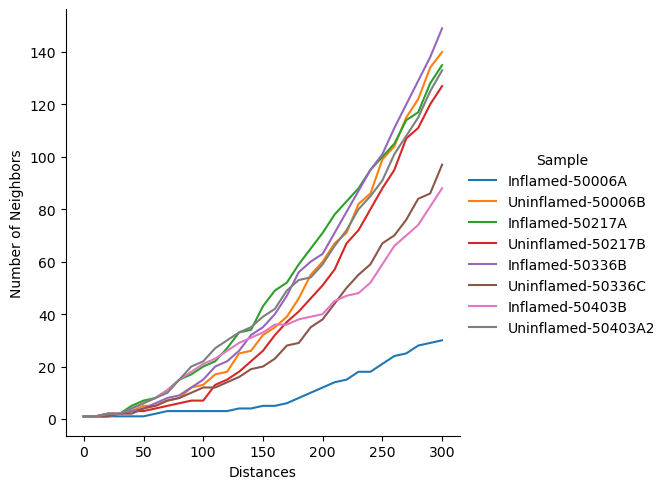

In [54]:
neighbors = {}
for d in np.arange(0, 301, 10):
    nnb = {}
    for x in grids:
        point_tree = spatial.cKDTree(grids[x].obs[["imagerow", "imagecol"]])
        nnb[x] = point_tree.query_ball_point(point_tree.data[0], d)
    neighbors[d] = pd.Series([len(nnb[i]) for i in nnb], index=pd.Index(
        grids.keys(), name=col_sample_id))
neighbors = pd.concat(neighbors, names=["Distances"]).unstack(col_sample_id)
sb.relplot(neighbors.stack().to_frame("Number of Neighbors"), kind="line",
           hue=col_sample_id, x="Distances", y="Number of Neighbors")
neighbors

# Analysis

**Important Input**

`adj_axis`: Per `stlearn` documentation: "adjusting by no. of LRs tested per spot (LR), no. of spots tested per LR (spot), or no adjustment (None)".

`distance`: Per author on `stlearn` GitHub: Distance is the "pixel length as the radius from each spot center. We will query all the spots within that radius." Also see https://github.com/BiomedicalMachineLearning/stLearn/issues/199#issuecomment-1272672934.

**Important Output**

`grid.uns["lr_summary"]`: Summarizes results for each ligand-receptor pair (number of spots with L-R, number of significant spots, and p-values).

`grid.obsm["lr_scores"]`: Ligand-receptor pair scores.

`grid.obsm["lr_sig_scores"]`: Rows = spots and columns = ligand-receptor pairs. Per `stLearn` GitHub issue, "Positive values in this matrix indicate significance of the LR in the respective spot (non-significant spots are set to zero)." It has the same index as in `grid.uns["lr_summary"]`.

### Run L-R & CCI

In [55]:
%%time

load = load_suffix not in [None, False]
distances = {}
for p in [[True, False], [False, True]]:  # iterate L-R, CCI analysis
    print(f"\n\n{'=' * 80}\n{'L-R' if p[0] else 'CCI'}\n{'=' * 80}\n\n")
    for x in grids:  # iterate samples
        print(f"\n\n{'*' * 40}\n{x}\n{'*' * 40}\n\n")

        # Re-Load Past Results if Already Done
        if "lrfeatures" in grids[x].uns and p[0] is True and load is True:
            distances[x] = grids[x].obs.loc[:, "distance"].iloc[0]
            print(grids[x].uns["lr_summary"])
            continue
        if f"lr_cci_{col_cell_type}" in grids[x].uns and (
                p[1] is True and load is True):
            print(f"Results stored in `.uns['lr_cci_{col_cell_type}']`")
            continue

        # Store Distance & Other Options
        ddd = min(neighbors[x].index.values[np.where(np.array(
            neighbors[x].apply(lambda y: y >= min_med_neighbors)))[0]]
                  )  # least distance >= specified # of median neighbors
        distances[x] = ddd if distance == "auto" else distance  # auto vs. #
        grids[x].obs.loc[:, "min_med_neighbors"] = min_med_neighbors if (
            distance == "auto") else np.nan  # store option to choose distance
        kws = dict(distance=distances[x], min_spots=min_spots,
                   n_pairs=n_pairs,
                   adj_method=adj_method, adj_axis=adj_axis,
                   pval_adj_cutoff=pval_adj_cutoff,
                   cell_prop_cutoff=cell_prop_cutoff, n_perms=n_perms,
                   organism=organism, resource=resource)
        if p[0] is True:
            print(f"n_pairs = {n_pairs}; distance = {distances[x]}")
        for v in kws:  # store keyword arguments in .obs
            grids[x].obs.loc[:, v] = str(kws[v])
        grids[x] = analyze_lr_spatial(grids[x], col_cell_type, n_jobs=n_jobs,
                                      do_lr=p[0], do_cci=p[1], **kws)
        if write_suffix not in [None, False]:
            grid = grids[x].copy()
            for e in grid.uns["lrfeatures"]:
                grid.uns["lrfeatures"][e] = grid.uns["lrfeatures"][
                    e].astype(np.float64)  # avoid write error
            grid.uns["lrfeatures"] = grids[x].uns[
                "lrfeatures"].astype(np.float64)  # avoid write error
            for e in ["lrfeatures", "lr_summary", "lr_summary_preadjust"]:
                if e in grid.uns:  # avoid write errors
                    ix_o = grid.uns[e].index.names
                    ixs = [u if u else "ix" for u in ix_o]  # rename "None"
                    grid.uns[e] = grid.uns[e].rename_axis(ixs).reset_index()
                    for k in ixs:
                        grid.uns[e] = grid.uns[e].astype({k: str})
                    grid.uns[e] = grid.uns[e].set_index(ixs).rename_axis([
                        u if u else "i" for u in ix_o])
            _ = grid.uns.pop(f"stlearn_label_transfer_{col_cell_type}", None)
            grid.write_h5ad(os.path.join(
                out_dir, f"{x}_stlearn{write_suffix}.h5ad"))  # write object



L-R




****************************************
Inflamed-50006A
****************************************


             n_spots  n_spots_sig  n_spots_sig_pval  \
COL1A2_CD44     9482         2499              5883   
COL1A1_CD44     9435         2267              5074   
IL6_IL6ST       6593          243              1202   
LY9_LY9         3345          231               661   
IL1B_IL1R2      2065          126               204   
OSM_IL6ST       2702           81               328   
IL11_IL6ST      2964           75               348   
CSF1_CSF1R      7116           72               336   
LGALS9_CD44     8616           53               330   
IL1A_IL1R2       492           43                97   
PLAU_PLAUR      4193           35               138   
IL34_CSF1R      3967           33               122   
IL10_IL10RA     4519           28               256   
MMP9_CD44       3345           16               165   
IL10_IL10RB     5066           12                37   
IFNG_IFNGR

KeyboardInterrupt: 

### Results Summaries

#### Dataframe

In [6]:
summaries = pd.concat([grids[x].uns["lr_summary"] for x in grids],
                      keys=grids.keys(), names=[col_sample_id, "L-R"])
lr_sig_df = pd.concat([pd.DataFrame(
    grids[x].obsm["lr_sig_scores"], index=grids[x].obs_names.values,
    columns=grids[x].uns["lr_summary"].index.values) for x in grids],
                      keys=grids.keys(), names=[col_sample_id, "L-R"])
summaries = summaries.assign(Ratio=summaries.n_spots_sig / summaries.n_spots)
summaries = summaries.join(m_d[[col_subject, col_condition]])  # join metadata
summaries = summaries.join(pd.Series([
    grids[x].n_obs for x in grids], index=pd.Index(
        grids, name=col_sample_id)).to_frame("N Spots (Sample)"))
summaries.loc[:, "Ratio (Significant Spots to N Spots Sample)"] = (
    summaries["n_spots_sig"] /  summaries["N Spots (Sample)"])
summaries

n_spots  n_spots_sig  n_spots_sig_pval  \
Sample             L-R                                                   
Inflamed-50006A    COL1A2_CD44     9482         2499              5883   
                   COL1A1_CD44     9435         2267              5074   
                   IL6_IL6ST       6593          243              1202   
                   LY9_LY9         3345          231               661   
                   IL1B_IL1R2      2065          126               204   
                   OSM_IL6ST       2702           81               328   
                   IL11_IL6ST      2964           75               348   
                   CSF1_CSF1R      7116           72               336   
                   LGALS9_CD44     8616           53               330   
                   IL1A_IL1R2       492           43                97   
                   PLAU_PLAUR      4193           35               138   
                   IL34_CSF1R      3967           33               122   
                   IL10_IL10RA     4519           28               256   
                   MMP9_CD44       3345           16               165   
                   IL10_IL10RB     5066           12                37   
                   IFNG_IFNGR1     2997           11                60   
                   IL22_IL10RA     1958            7                61   
                   CSF2_CSF2RB      610            4                15   
                   IFNG_IFNGR2     2590            3                13   
                   CSF2_IL3RA       374            3                20   
                   IL22_IL10RB     2225            3                10   
                   CSF2_CSF2RA      499            3                10   
Uninflamed-50006B  COL1A1_CD44     1948          103               522   
                   COL1A2_CD44     1950          103               551   
                   CSF1_CSF1R      1451           13                47   
                   IL10_IL10RB      822           11                59   
                   LY9_LY9          749           10                59   
                   PLAU_PLAUR       648           10                22   
                   IL6_IL6ST        464            7                44   
                   IL22_IL10RB      214            6                22   
                   LGALS9_CD44     2066            6                10   
                   OSM_IL6ST        256            5                17   
                   IFNG_IFNGR2      167            3                 4   
                   IFNG_IFNGR1      170            2                 4   
                   IL10_IL10RA      611            1                12   
                   CSF2_CSF2RB       28            0                 0   
                   IL1A_IL1R2       131            0                 0   
                   IL1B_IL1R2       358            0                 0   
                   IL22_IL10RA      147            0                 0   
                   IL34_CSF1R       532            0                 4   
                   CSF2_CSF2RA       25            0                 0   
                   MMP9_CD44        865            0                27   
                   CSF2_IL3RA        25            0                 1   
                   IL11_IL6ST       336            0                 8   
Inflamed-50217A    COL1A2_CD44   128305        52202             99776   
                   COL1A1_CD44   126942        38021             74529   
                   LGALS9_CD44   112772         2701              8387   
                   IL6_IL6ST      50222         1760              6121   
                   LY9_LY9        24583         1671              4559   
                   MMP9_CD44      57369         1226              3984   
                   CSF1_CSF1R     80745         1086              4089   
                   PLAU_PLAUR     64116          950              2444   
                   IL11_IL6ST     23

#### Plot by Patient

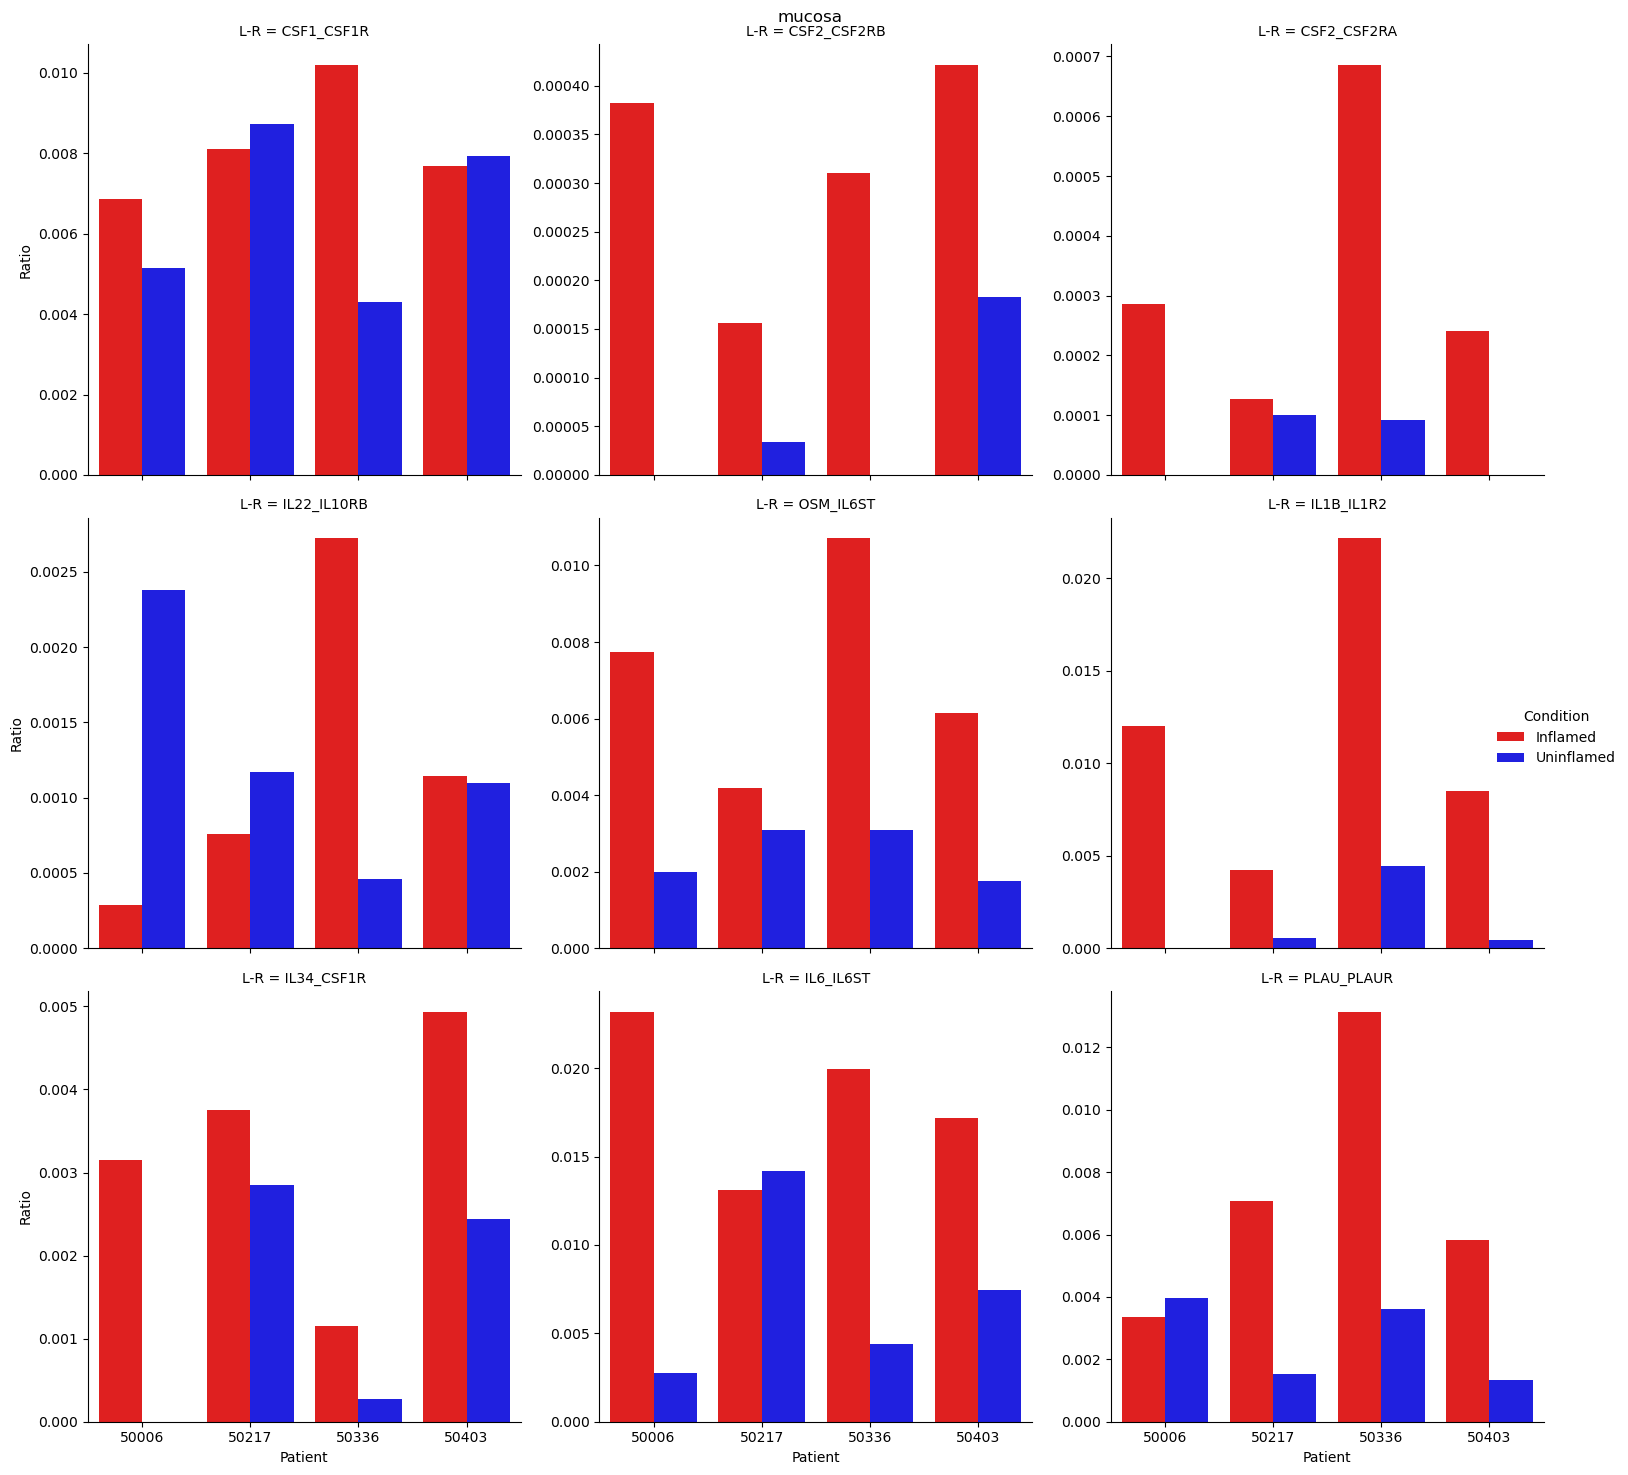

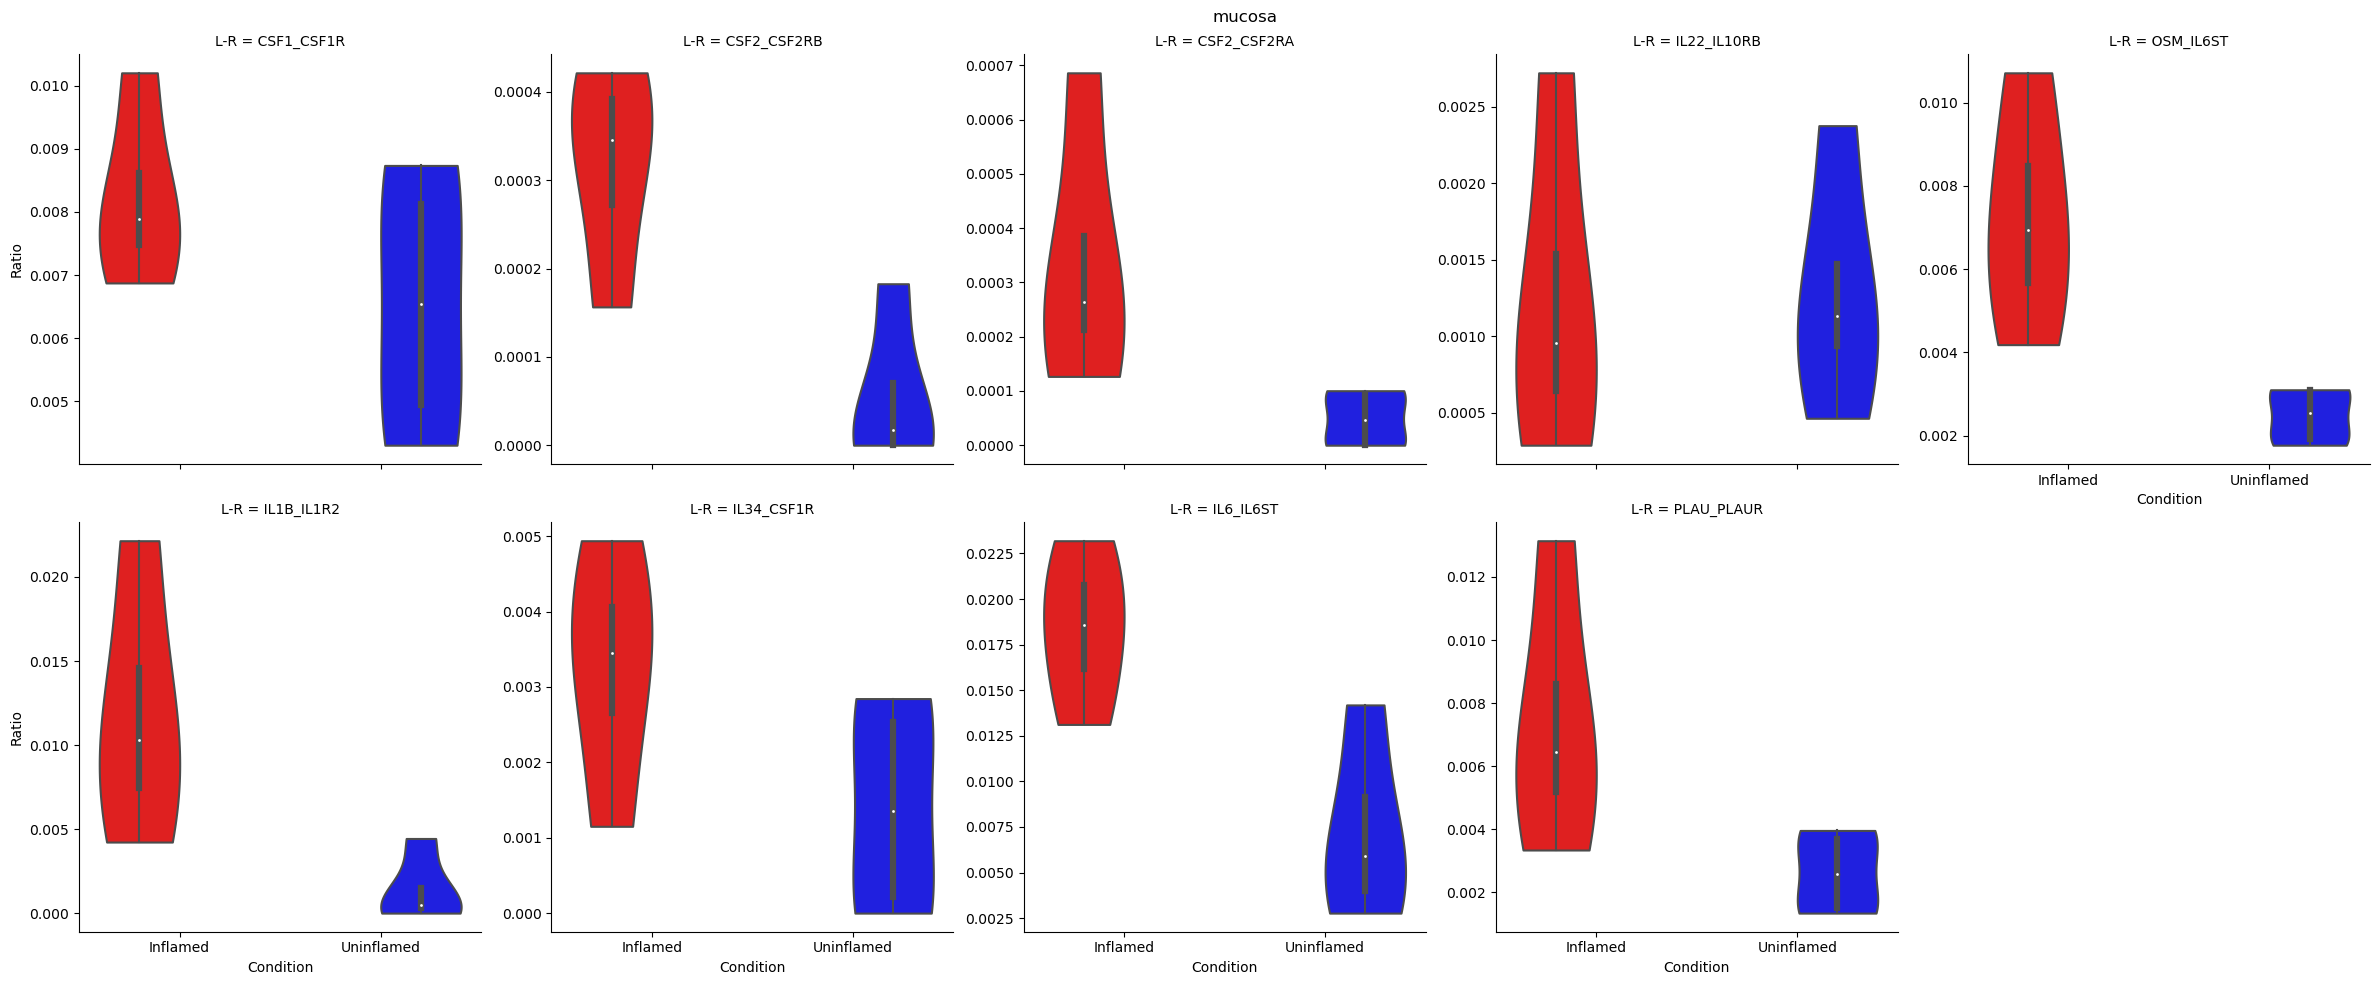

In [37]:
    x = "_mucosa"
    ppp = ["CSF1_CSF1R", "CSF2_CSF2RB", "CSF2_CSF2RA", "IL22_IL10RB",
           "OSM_IL6ST", "IL1B_IL1R2", "IL34_CSF1R", "IL6_IL6ST", "PLAU_PLAUR"]
    sums = pd.read_excel("/home/elizabeth/elizabeth/projects/csf2rb/analysis/"
                         f"stlearn_summary_lr{x}_hires_hipair_hiperm.xlsx",
                         index_col=[0, 1])
    sums = sums.set_index([col_condition, col_subject], append=True)[[
        "Ratio (Significant Spots to N Spots Sample)"]].rename({
            "Ratio (Significant Spots to N Spots Sample)": "Of Sample Total"
            }, axis=1).rename_axis(
                "Denominator", axis=1).stack().to_frame("Ratio")
    fig = sb.catplot(sums.loc[:, ppp, :].reset_index(),
                     margin_titles=True, kind="bar",
                     x=col_subject, y="Ratio", palette=["r", "b"],
                     hue=col_condition, hue_order=[key_infl, key_uninfl],
                     sharey=False, col="L-R", col_wrap=3)
    fig.figure.suptitle("_".join(x.split("_")[1:]))
    fig.figure.tight_layout()
    plt.subplots_adjust(right=0.95)
    fig = sb.catplot(sums.loc[:, ppp, :].reset_index(),  # kind="bar",
                     margin_titles=True, kind="violin", cut=0,
                     x=col_condition, y="Ratio", palette=["r", "b"],
                     hue=col_condition, hue_order=[key_infl, key_uninfl],
                     sharey=False, col="L-R", col_wrap=5)
    fig.figure.suptitle("_".join(x.split("_")[1:]))
    fig.figure.tight_layout()
    plt.subplots_adjust(right=0.95)

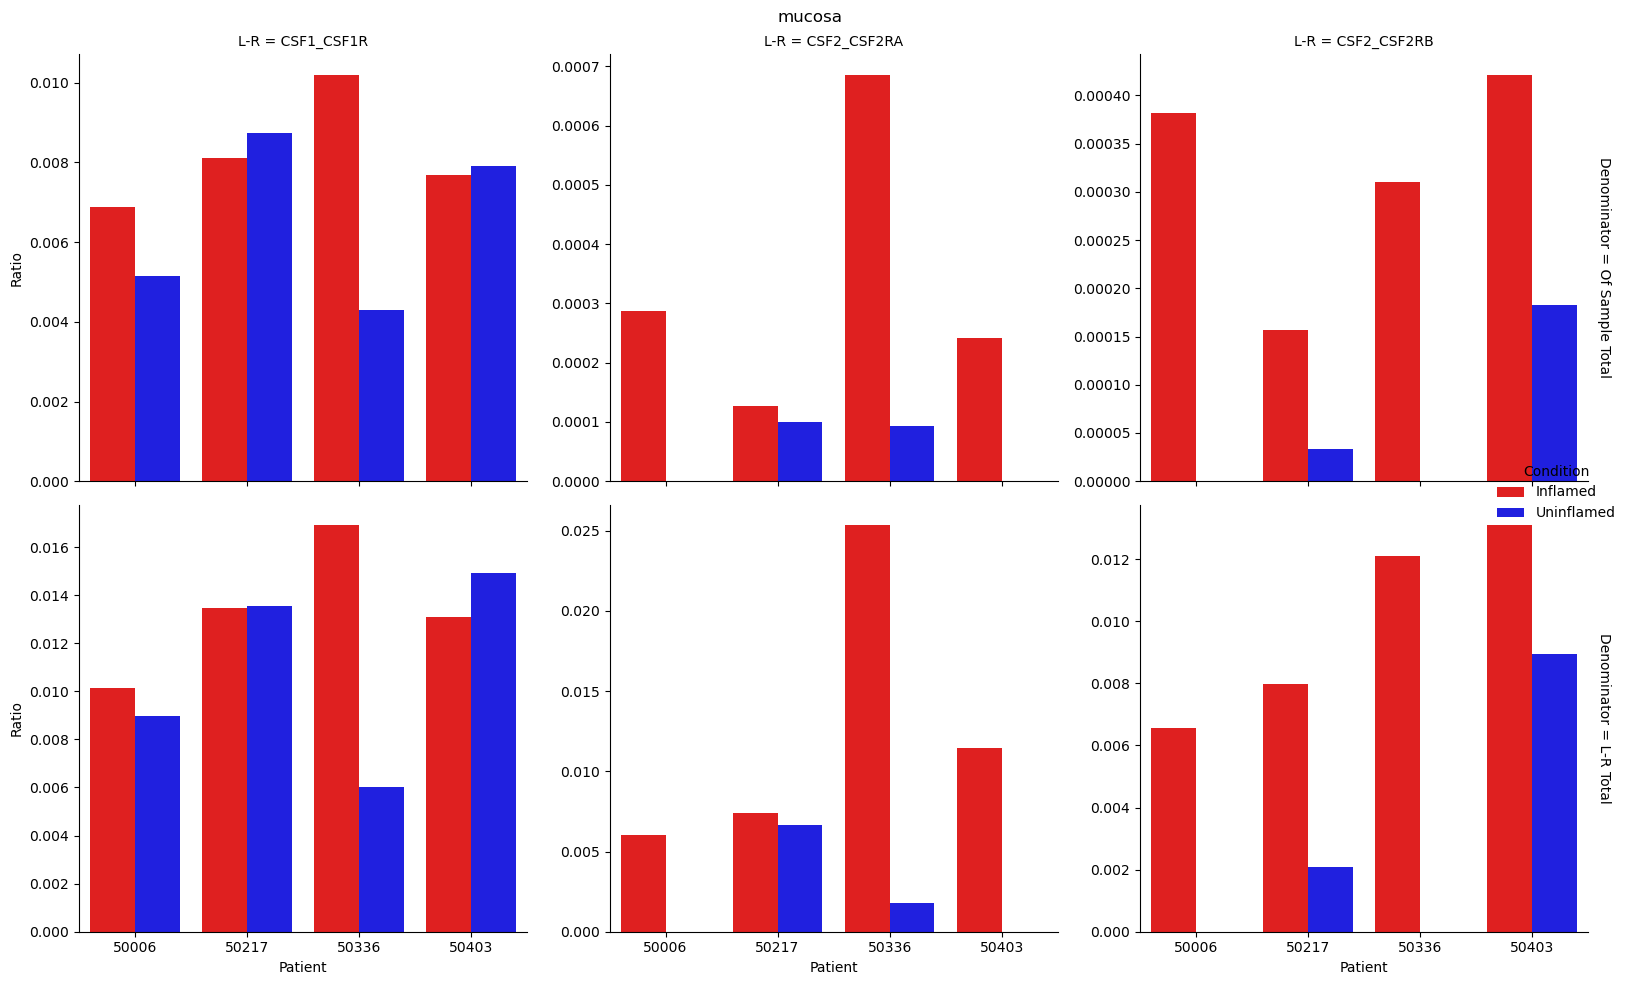

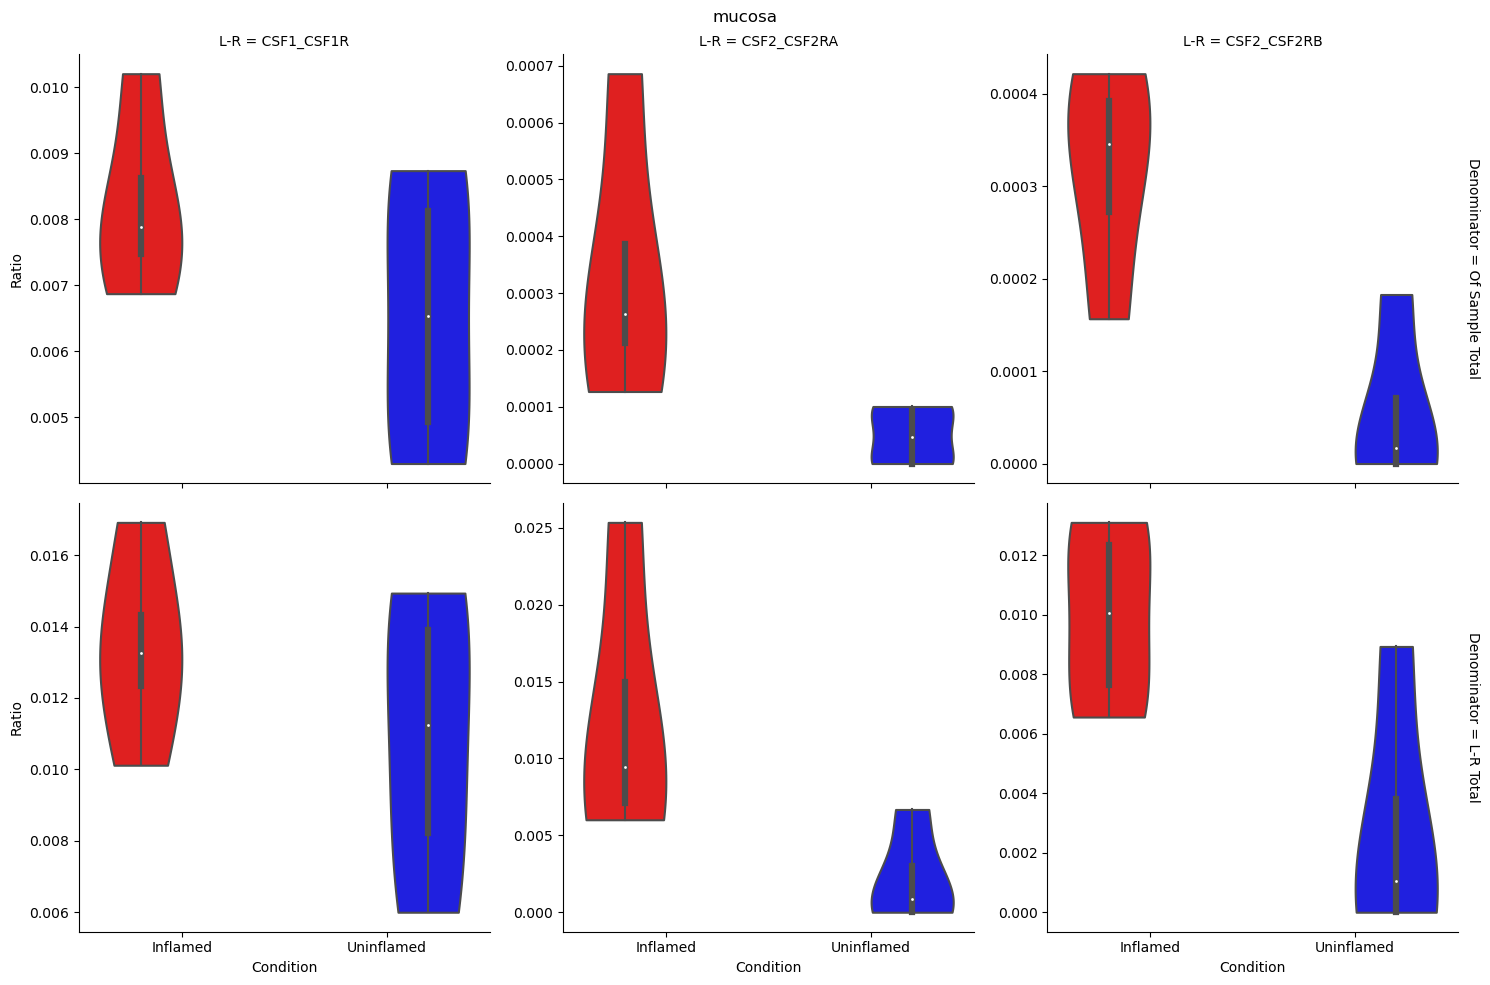

In [21]:
    x = "_mucosa"
    sums = pd.read_excel("/home/elizabeth/elizabeth/projects/csf2rb/analysis/"
                         f"stlearn_summary_lr{x}_hires_hipair_hiperm.xlsx",
                         index_col=[0, 1])
    sums = sums.set_index([col_condition, col_subject], append=True)[[
        "Ratio (Significant Spots to N Spots Sample)", "Ratio"]].rename({
            "Ratio (Significant Spots to N Spots Sample)": "Of Sample Total",
            "Ratio": "L-R Total"}, axis=1).rename_axis(
                "Denominator", axis=1).stack().to_frame("Ratio")
    fig = sb.catplot(sums.loc[:, plot_lr, :].reset_index(),
                     margin_titles=True, kind="bar",
                     x=col_subject, y="Ratio", palette=["r", "b"],
                     hue=col_condition, hue_order=[key_infl, key_uninfl],
                     sharey=False, col="L-R", row="Denominator")
    fig.figure.suptitle("_".join(x.split("_")[1:]))
    fig.figure.tight_layout()
    fig = sb.catplot(sums.loc[:, plot_lr, :].reset_index(),  # kind="bar",
                     margin_titles=True, kind="violin", cut=0,
                     x=col_condition, y="Ratio", palette=["r", "b"],
                     hue=col_condition, hue_order=[key_infl, key_uninfl],
                     sharey=False, col="L-R", row="Denominator")
    fig.figure.suptitle("_".join(x.split("_")[1:]))
    fig.figure.tight_layout()

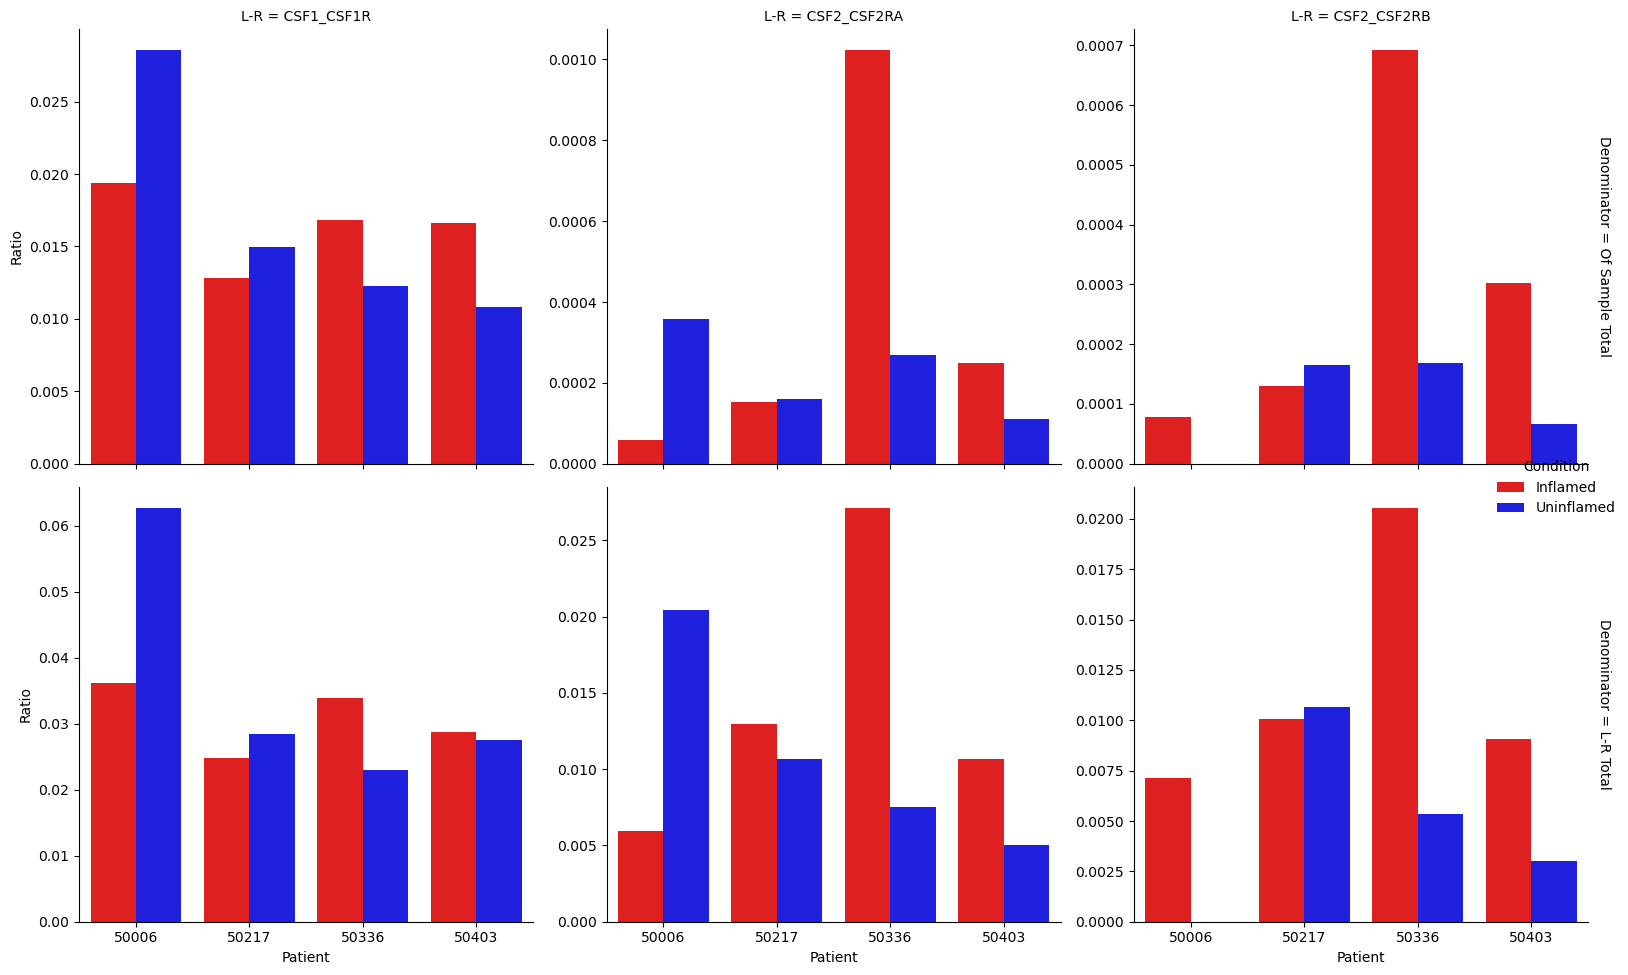

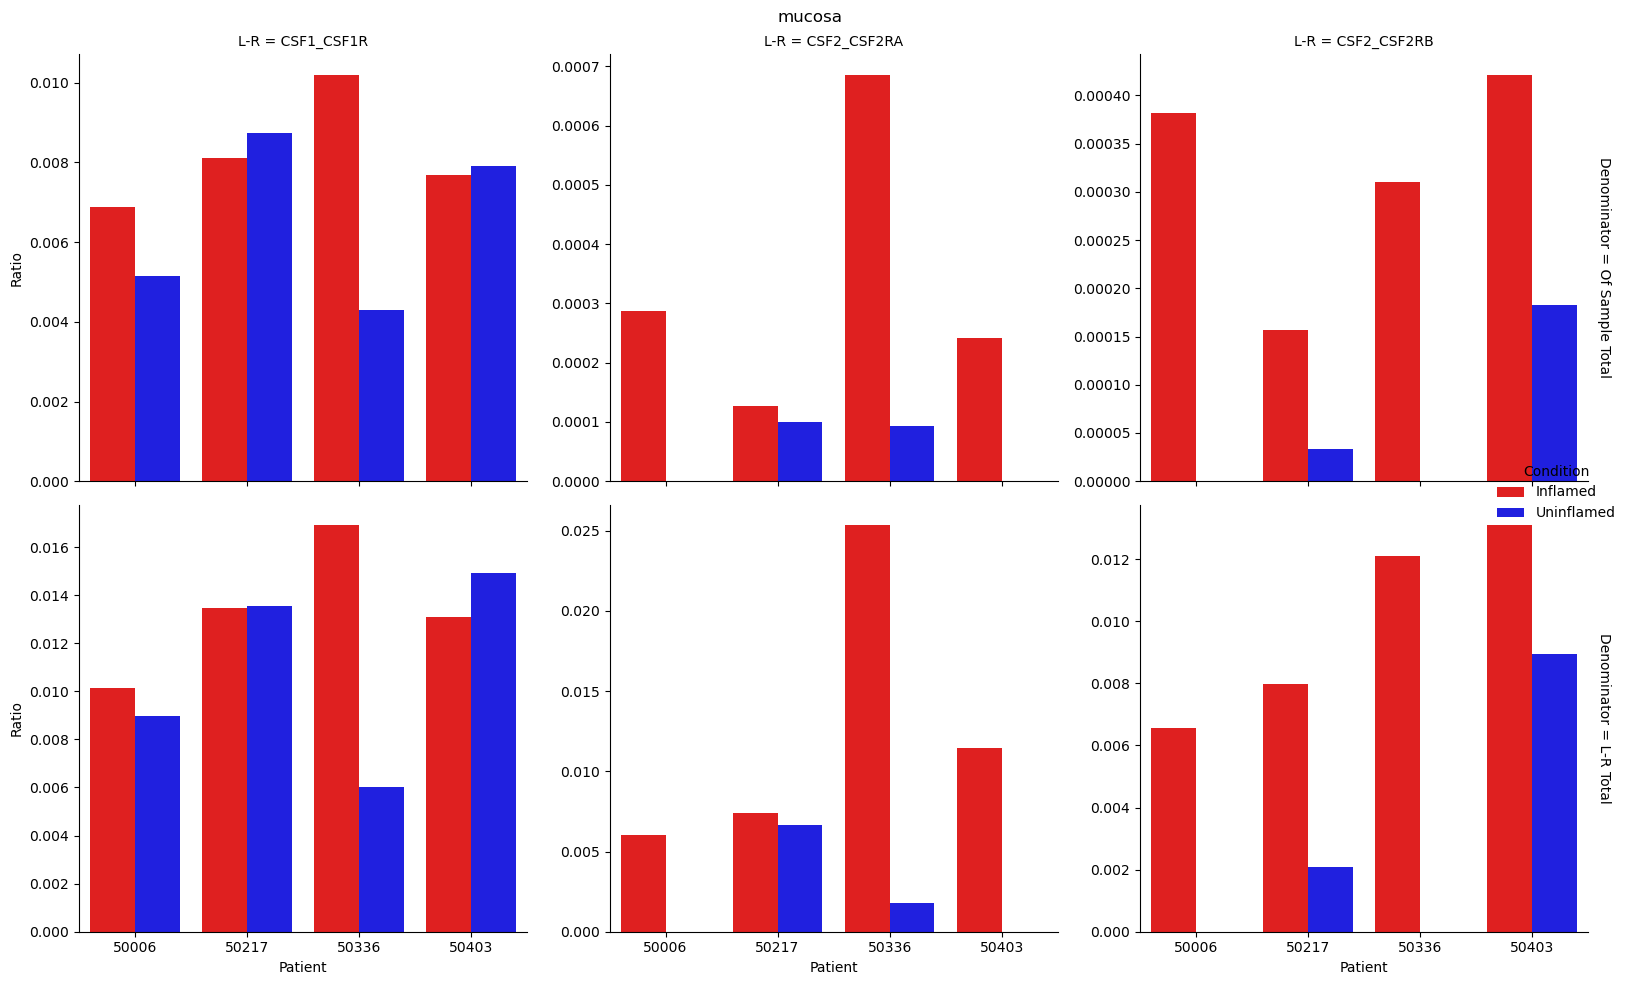

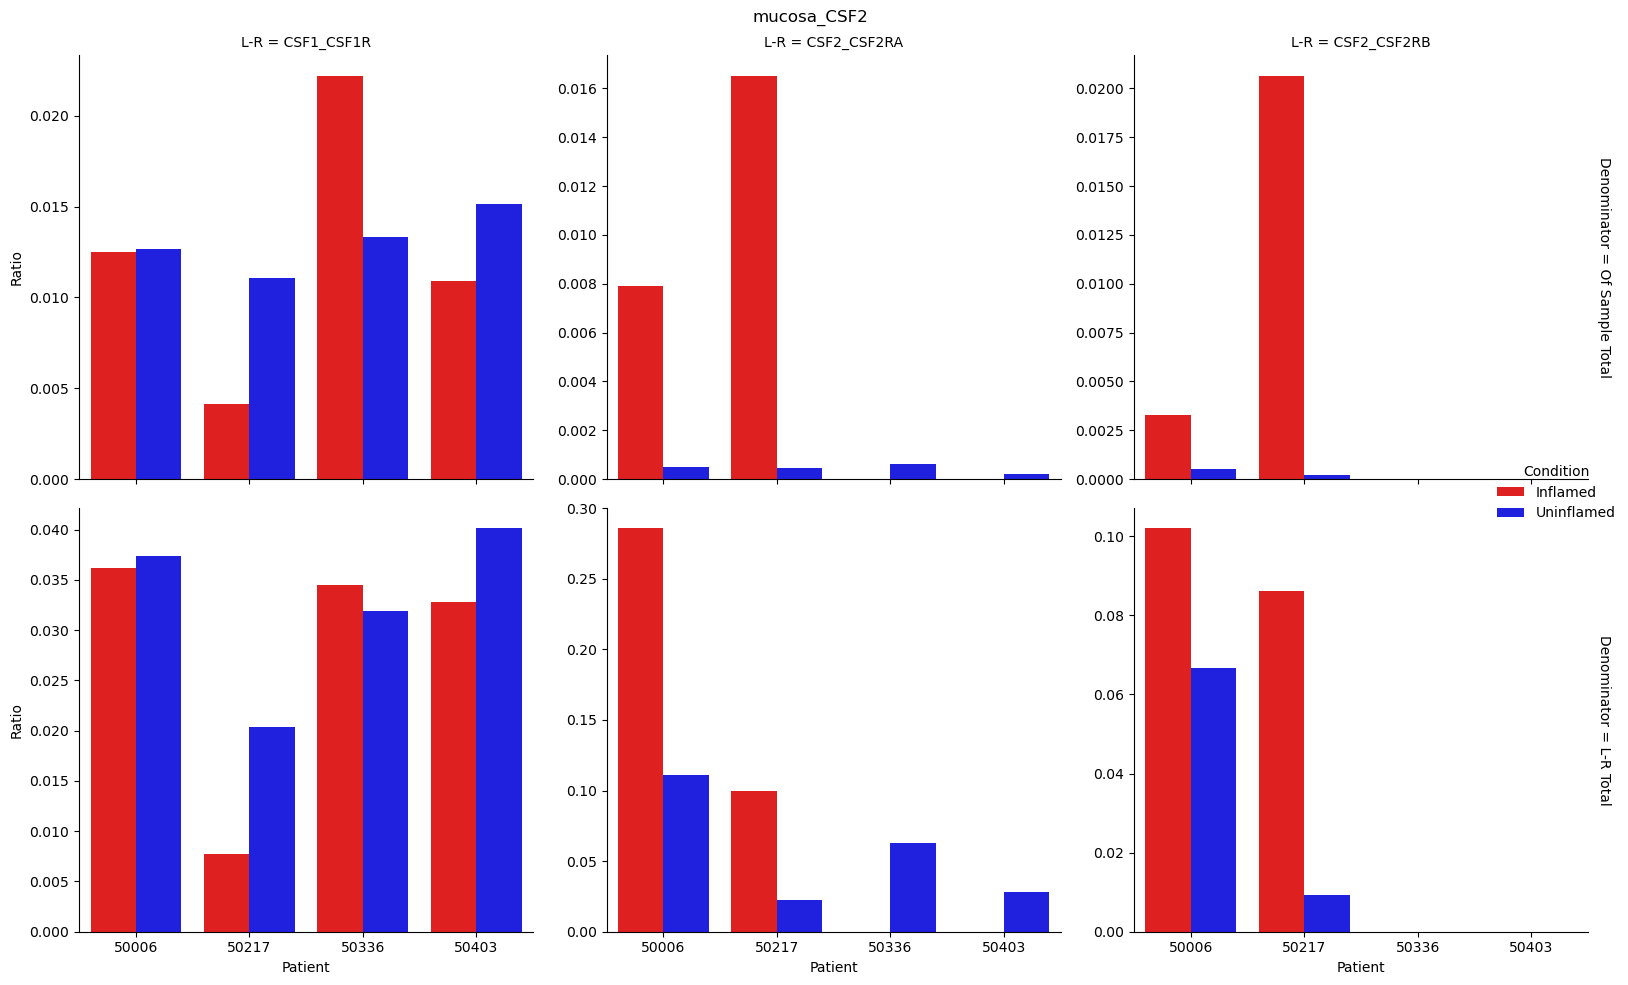

In [15]:
for x in ["", "_mucosa", "_mucosa_CSF2"]:
    sums = pd.read_excel("/home/elizabeth/elizabeth/projects/csf2rb/analysis/"
                         f"stlearn_summary_lr{x}_hires_hipair_hiperm.xlsx",
                         index_col=[0, 1])
    sums = sums.set_index([col_condition, col_subject], append=True)[[
        "Ratio (Significant Spots to N Spots Sample)", "Ratio"]].rename({
            "Ratio (Significant Spots to N Spots Sample)": "Of Sample Total",
            "Ratio": "L-R Total"}, axis=1).rename_axis(
                "Denominator", axis=1).stack().to_frame("Ratio")
    fig = sb.catplot(sums.loc[:, plot_lr, :].reset_index(),
                     margin_titles=True, kind="bar",
                     x=col_subject, y="Ratio", palette=["r", "b"],
                     hue=col_condition, hue_order=[key_infl, key_uninfl],
                     sharey=False, col="L-R", row="Denominator")
    fig.figure.suptitle("_".join(x.split("_")[1:]))
    fig.figure.tight_layout()

#### Plot Overall

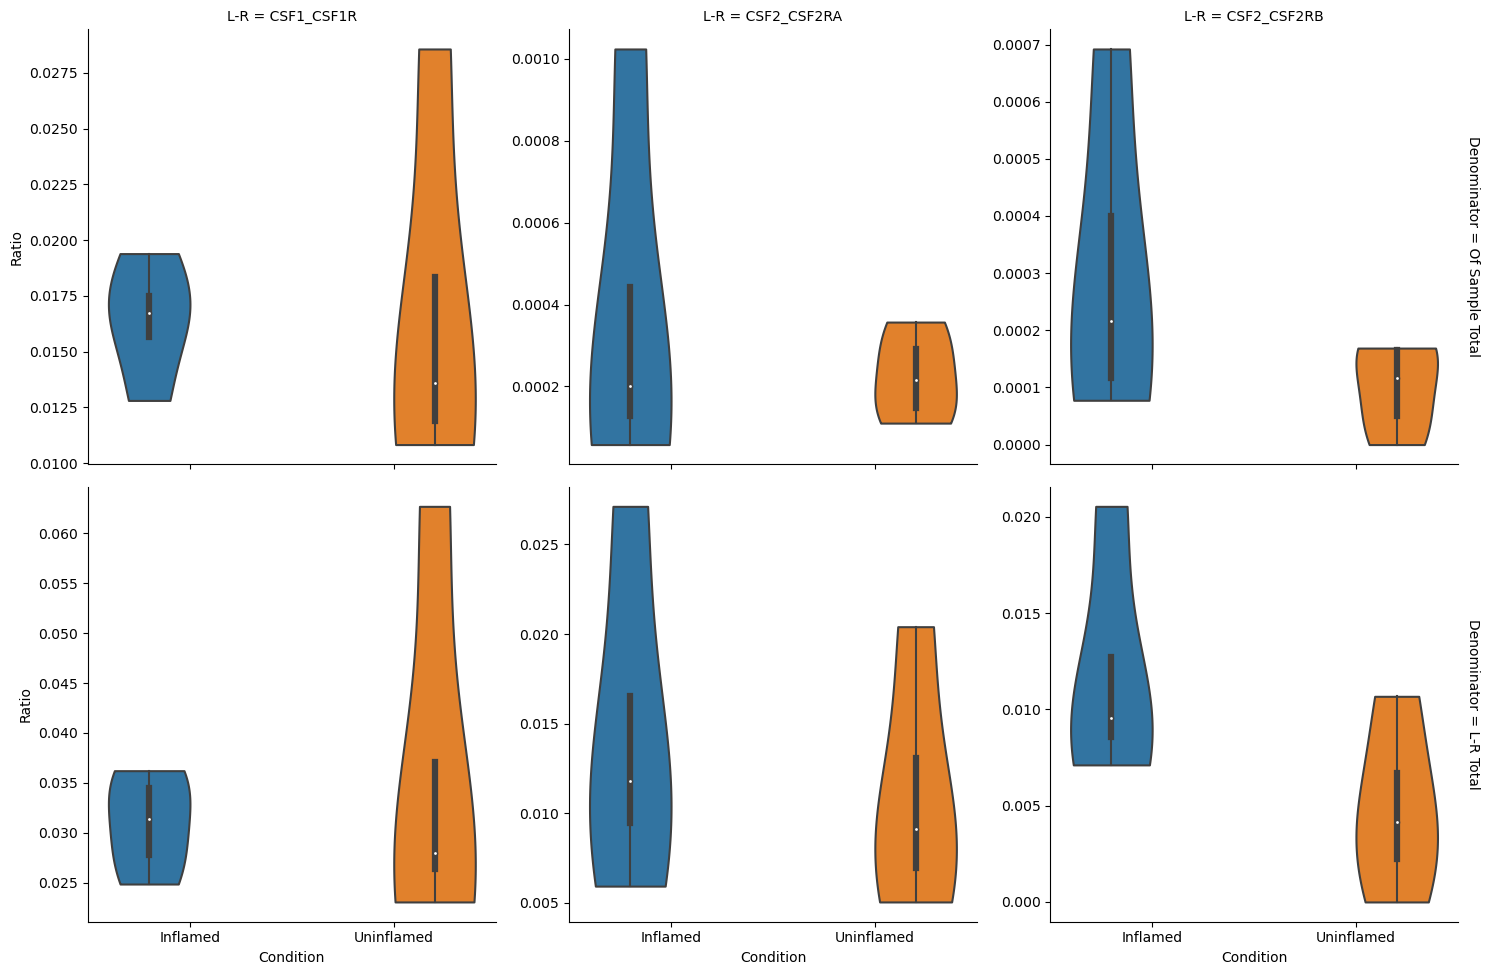

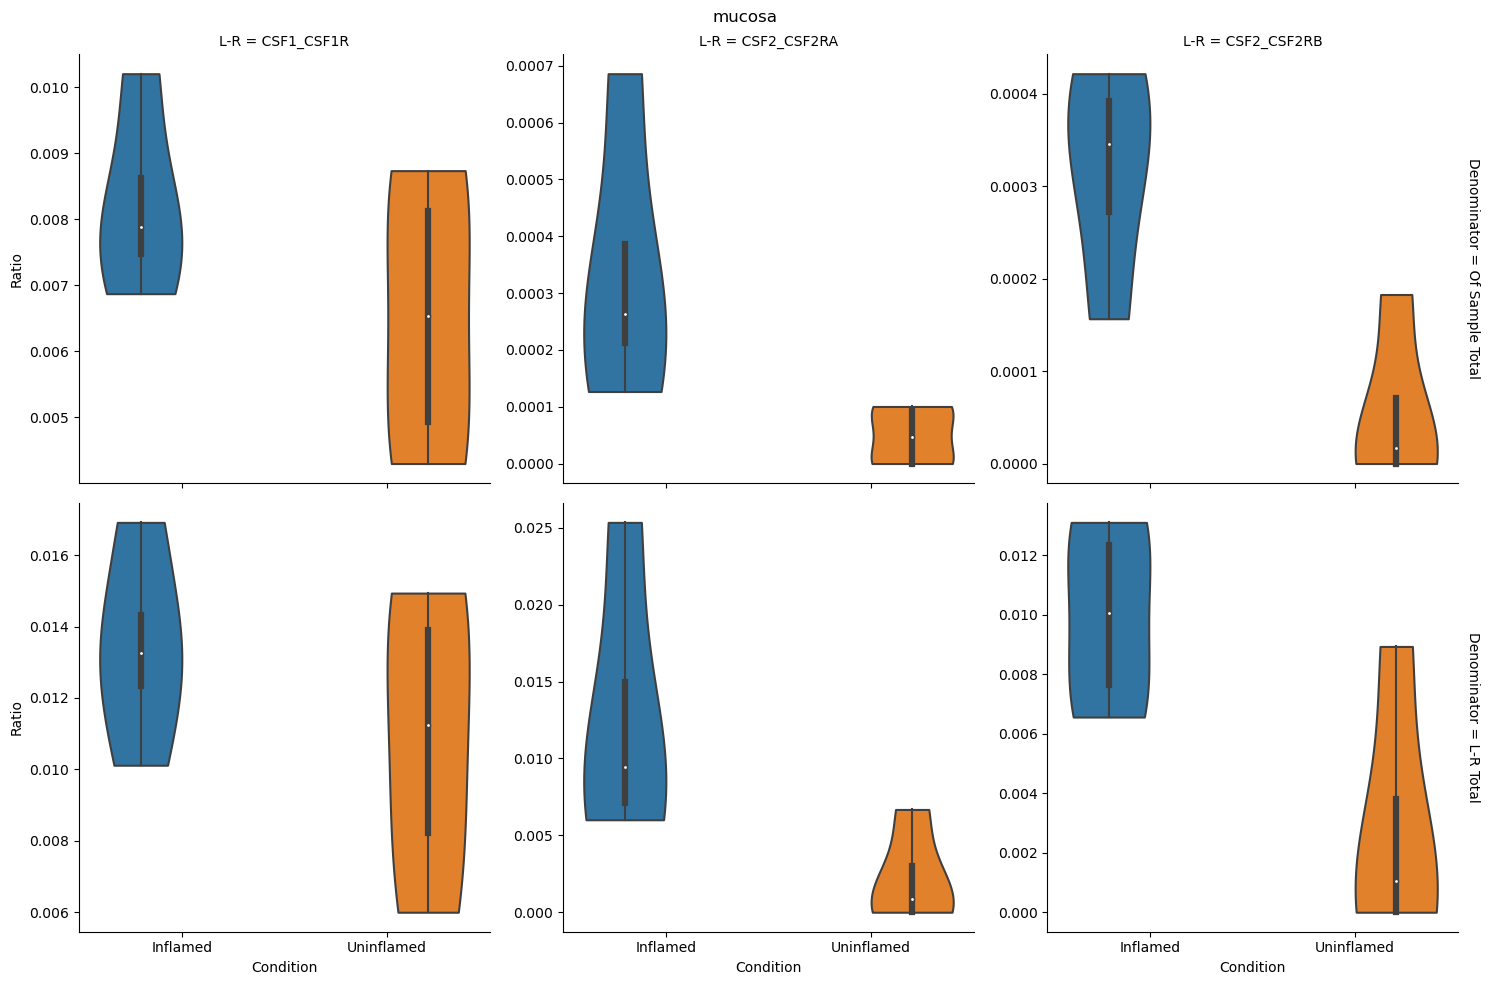

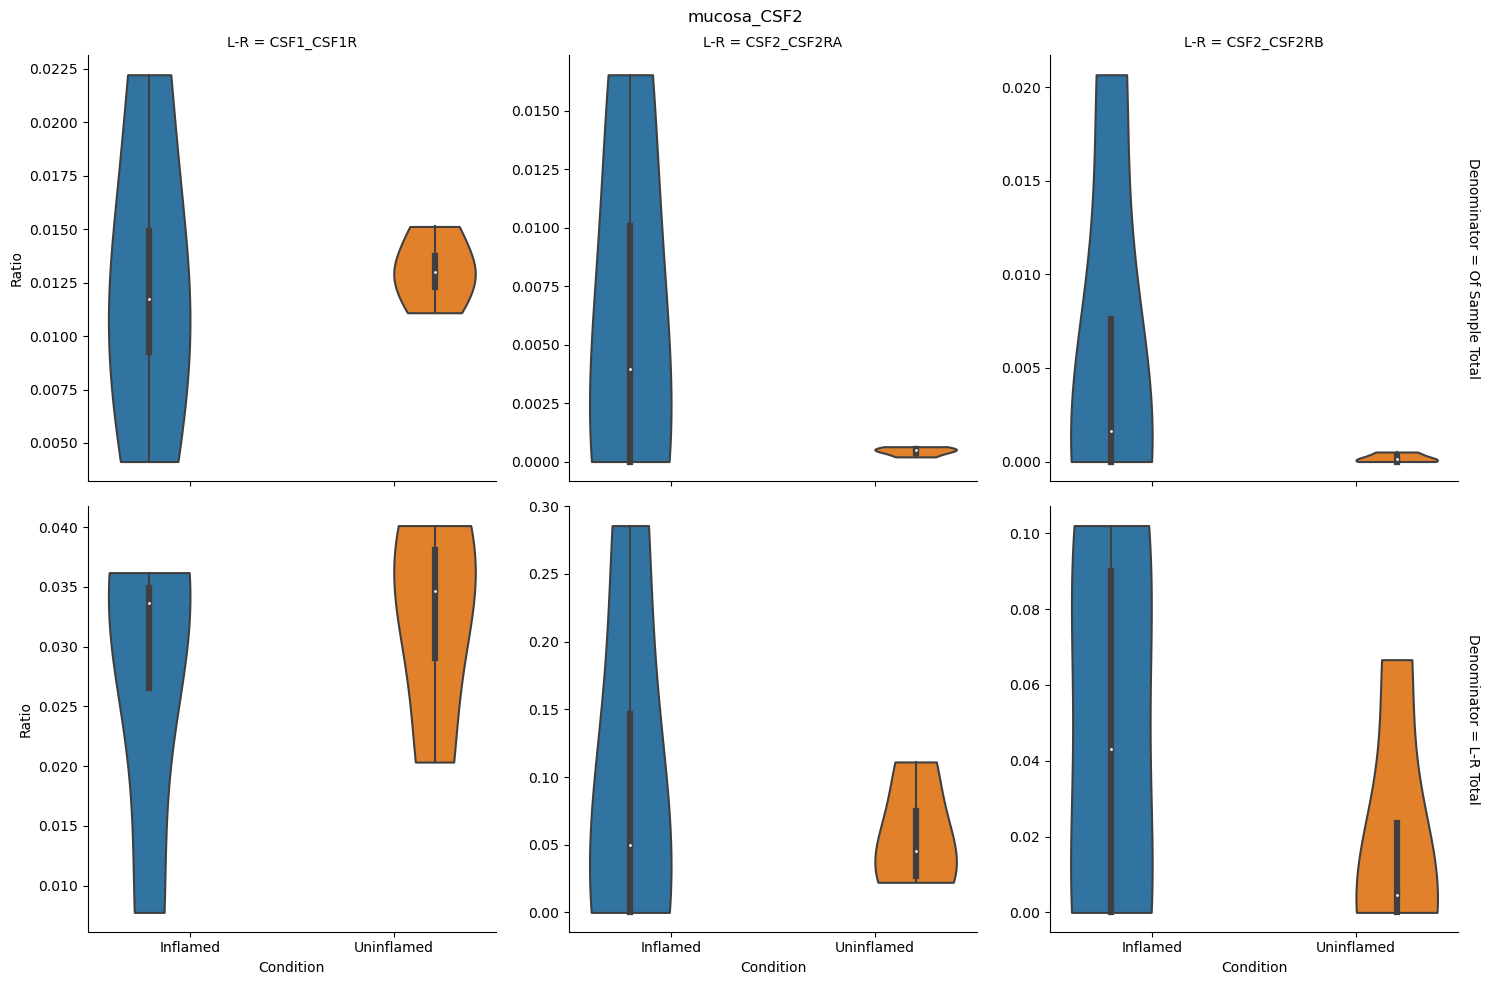

In [12]:
for x in ["", "_mucosa", "_mucosa_CSF2"]:
    sums = pd.read_excel("/home/elizabeth/elizabeth/projects/csf2rb/analysis/"
                         f"stlearn_summary_lr{x}_hires_hipair_hiperm.xlsx",
                         index_col=[0, 1])
    sums = sums.set_index(col_condition, append=True)[[
        "Ratio (Significant Spots to N Spots Sample)", "Ratio"]].rename({
            "Ratio (Significant Spots to N Spots Sample)": "Of Sample Total",
            "Ratio": "L-R Total"}, axis=1).rename_axis(
                "Denominator", axis=1).stack().to_frame("Ratio")
    fig = sb.catplot(sums.loc[:, plot_lr, :].reset_index(),  # kind="bar",
                     margin_titles=True, kind="violin", cut=0,
                     x=col_condition, y="Ratio", palette=["r", "b"],
                     hue=col_condition, hue_order=[key_infl, key_uninfl],
                     sharey=False, col="L-R", row="Denominator")
    fig.figure.suptitle("_".join(x.split("_")[1:]))
    fig.figure.tight_layout()

In [33]:
# summaries.to_excel("/home/elizabeth/elizabeth/projects/csf2rb/analysis/"
#                    f"stlearn_summary_lr{write_suffix}.xlsx")

## Meta-Analysis

Per `stlearn` author [here](https://github.com/BiomedicalMachineLearning/stLearn/issues/185):
> use compositional data analysis (CoDa, Tom Quinn @tpq has alot of good papers/reviews on this, e.g. review) on the ratios, (number of sig spots/ total spots), for each sample. 
> 
> transform the ratios from Atchison geomety to euclidean geometry using the centred-log-ratio (clr) transformation (available in scikit-bio)
> 
>  perform independent Welch's t-test using scipy on the clrs between conditions, or other statistical tests (e.g. ANOVA).

### Plots

In [ ]:
lvls = [key_uninfl, key_infl, key_stric] if (key_stric in list(
    summaries.reset_index()[col_condition])) else [key_uninfl, key_infl]
fig, axes = plt.subplots(len(lvls), 1, squeeze=False)
axes_dict = {key_infl: 0, key_uninfl: 1, key_stric: 2}
for x in grids:  # plot L-R ranks for all
    st.pl.lr_summary(grid, n_top=n_top, ax=axes.flatten()[
        axes_dict[m_d.loc[x][col_condition]]])

In [ ]:
lvls = [key_uninfl, key_infl, key_stric] if (key_stric in list(
    summaries.reset_index()[col_condition])) else [key_uninfl, key_infl]
r_dict = {key_infl: 0, key_uninfl: 1, key_stric: 2}
c_dict = dict(zip(summaries.reset_index()[col_subject].unique(), np.arange(
    len(summaries.reset_index()[col_subject].unique()) + 1)))
for p in plot_lr:
    fig, axes = plt.subplots(len(lvls), len(summaries.reset_index()[
        col_subject].unique()), squeeze=False)
    for i, x in enumerate(grids):  # plot L-R ranks for all
        st.pl.lr_plot(grid, p, "lr_scores", fig=fig, title=p,
                      ax=axes[r_dict[m_d.loc[x][col_condition]],
                              c_dict[m_d.loc[x][col_subject]]])

In [ ]:
sb.catplot(summaries.loc[:, plot_lr, :].reset_index(), x="L-R", y="Ratio",
           hue=col_condition, palette=["b", "r", "y"],
           hue_order=lvls, kind="violin", cut=0)

### T-Test

In [44]:
mod_lrs = [x for x in summaries.reset_index()["L-R"].unique() if any(
    (any((j in x for j in i.split("_"))) for i in plot_lr))]
lmods = {}

for g in plot_lr:
    sums = summaries.loc[:, g, :].set_index([
        col_subject, col_condition])[["Ratio"]]
    reps = {}
    for x in summaries.loc[:, g, :].set_index([
            col_subject, col_condition]).index:
        if x in sums.index and sums.loc[x].shape[
                0] > 1:  # distinguish subject-condition replicates index
            rep_ids = [f"{s}-{i}"for i, s in enumerate(
                sums.loc[x].reset_index()[col_subject])]
            sums = pd.concat([sums.drop(x), sums.loc[x].assign(
                subj=rep_ids).reset_index(0, drop=True).rename({
                        "subj": col_subject}, axis=1).reset_index().set_index(
                            sums.index.names)])
            reps[x] = rep_ids
    if len(reps) > 0 and sums["Ratio"].unstack(col_condition).apply(
        lambda x: x.isnull()).any().any():
            for k in reps:
                if k[0] in sums.reset_index()[col_subject].unique(
                    ):  # if different subject-condition only had 1 replicate
                    sums = sums.rename({k[0]: reps[k][0]}
                                )  # unstack with 1st replicate
    sums = sums["Ratio"].unstack(col_condition)
    # print(sums)
    lmods[g] = scipy.stats.ttest_rel(np.array(sums)[0], np.array(sums)[1],
                                     nan_policy="omit")
    # lmods[g] = scipy.stats.ttest_ind(np.array(sums)[0], np.array(sums)[1],
    #                                  nan_policy="omit", equal_var=False)
res_t = pd.concat([pd.Series([lmods[g].statistic, lmods[g].pvalue, lmods[
    g].confidence_interval(), lmods[g].df], index=["T", "P", "CI", "DF"])
                   for g in lmods], keys=lmods, names=["Gene"]).unstack(1)
# res_t = pd.concat([pd.Series([lmods[g].statistic, lmods[g].pvalue], index=[
#     "T", "P"]) for g in lmods], keys=lmods, names=["Gene"]).unstack(1)
res_t

,T,P,CI,DF
Gene,,,,
CSF1_CSF1R,-6.289872,0.100373,"(-0.011964246940761276, 0.0040411816601907645)",1
CSF2_CSF2RA,-1.537261,0.367159,"(-0.037508134081677566, 0.029411819712573648)",1
CSF2_CSF2RB,-5.266153,0.119467,"(-0.005987817348224525, 0.0024787883209157146)",1


### (M)LM

In [48]:
for x in summaries.reset_index()[col_sample_id].unique():
    summaries.loc[x, "Centered_Log_Ratio"] = clr(
        np.array(summaries.loc[x].Ratio.replace(
            0, 1e-100)))  # replace 0 with small #; transform spot ratios
lvls = [key_uninfl, key_infl, key_stric] if (key_stric in list(
    summaries.reset_index()[col_condition])) else [key_uninfl, key_infl]
mod_lrs = [x for x in summaries.reset_index()["L-R"].unique() if any(
    (any((j in x for j in i.split("_"))) for i in plot_lr))]
lmods = {}
for g in mod_lrs:
# or g in summaries.reset_index()["L-R"].unique():
    print(f"\n\n{'=' * 80}\n{g}\n{'=' * 80}\n\n")
    lmods[g] = Lmer(
        f"Centered_Log_Ratio ~ C({col_condition}) + (1 | {col_subject})",
        data=summaries.loc[:, g, :].replace(
            np.inf, np.nan).reset_index().dropna())
    # lmods[g] = Lm(
    #     f"Centered_Log_Ratio ~ C({col_condition})",
    #     data=summaries.loc[:, g, :].replace(
    #         np.inf, np.nan).reset_index().dropna())
    print(lmods[g].fit(factors={col_condition: lvls}))



CSF1_CSF1R




RRuntimeError: Error: No random effects terms specified in formula


# Plots

In [ ]:
def plot_spatial_lr(grid, col_cell_type, kind="results", figsize=None,
                    sig_spots=False, sig_cci=True, show_arrows=True,
                    stats=None, plot_lr=3, n_top=50, min_total=100,
                    plot_cci=True, **kwargs):
    """Plot QC & results from spatial LR & CCI analysis."""
    figs = {}
    f_s = (12, 6) if figsize is None else figsize
    if stats is None:
        # stats = ["lr_scores", "p_vals", "p_adjs", "-log10(p_adjs)"]
        stats = ["lr_scores", "p_vals", "p_adjs"]
    kind_all = ["qc", "results", "arrow", "map", "net", "chord"]
    kind = [kind_all if kind.lower() == "all" else kind.lower()] if (
        isinstance(kind, str)) else [k.lower() for k in kind]
    if plot_lr not in [False, None]:
        plot_lr = [plot_lr] if isinstance(plot_lr, str) else grid.uns[
            "lr_summary"].index.values[:int(plot_lr)] if isinstance(plot_lr, (
                int, float)) else list(plot_lr)  # use top N (plot_lr)
        ncols = 3 if len(plot_lr) > 3 else len(plot_lr)  # L-R facets (row)
        nrows = int(len(plot_lr) / ncols) if ncols > 1 else 1  # L-R columns
    if "lr_colors" in kwargs:
        kwargs["lr_colors"] = dict(zip(kwargs["lr_colors"], [
            mpl.colors.to_hex(kwargs["lr_colors"][u])
            for u in kwargs["lr_colors"]]))  # convert colors to hex

    # QC/Diagnostics (Metrics Shouldn't Correlate Much with L-R Expression)
    if "qc" in kind:
        print(f"\n\n{'*' * 40}\nQC Plots\n{'*' * 40}\n\n"
              "Expression frequency and L-R/CCI metrics shouldn't correlate much"
              "; otherwise, increase `n_perms` and/or `n_pairs`.")
        try:
            st.pl.lr_diagnostics(grid, figsize=(10, 2.5))  # QC
            figs["qc_lr_diagnostics"] = plt.gcf()
            st.pl.lr_n_spots(grid, n_top=n_top, figsize=(11, 3), max_text=100)
            figs["qc_lr_spots"] = plt.gcf()
        except Exception:
            traceback.print_exc()
        if f"per_lr_cci_{col_cell_type}" in grid.uns and (
                plot_cci is True):  # if CCI has been run
            try:
                st.pl.cci_check(grid, col_cell_type, figsize=(16, 5))
                figs["qc_cci"] = plt.gcf()
                figs["qc_cci"].suptitle("CCI Check: Interactions & cell type "
                                        "frequency shouldn't correlate much")
            except Exception:
                traceback.print_exc()
                print("\n\nCCI QC plot failed")

    # Results Summary (Rankings of L-R Pairs by Number of Significant Spots)
    if "results" in kind:
        print(f"\n\n{'*' * 40}\nResults Plots\n{'*' * 40}\n\n")
        st.pl.lr_summary(grid, n_top=n_top, figsize=f_s,
                         highlight_lrs=plot_lr)  # plot L-R ranks
        figs["lr_ranks"] = plt.gcf()
        if plot_lr is not False:
            fig, axes = kwargs.pop("fig", None), kwargs.pop("axes", None)
            if fig is None or axes is None:
                fig, axes = plt.subplots(ncols=len(stats), nrows=len(plot_lr),
                                         figsize=f_s)  # subplots: L-R pairs
            for r, lr in enumerate(plot_lr):  # iterate ligand-receptors
                # kws = {"show_color_bar": False, **kwargs}
                kws = {"show_color_bar": False}
                try:
                    for c, stat in enumerate(stats):  # iterate statistics
                        st.pl.lr_result_plot(
                            grid, use_result=stat, use_lr=lr,
                            fig=fig, ax=axes[r, c], **kws)  # plot L-R
                        axes[r, c].set_title(f"{lr} {stat}")
                except Exception:
                    traceback.print_exc()
                    print(f"Results summary plot error for {lr}")
            if fig is not None:
                fig.show()
            figs["results"] = fig, axes

    # Color Spot by Mean L-R Expression in Spots Connected by Arrow
    if "arrow" in kind:
        fig, axes = kwargs.pop("fig", None), kwargs.pop("axes", None)
        if fig is None or axes is None:
            fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                                     figsize=f_s, squeeze=False)
        for i, lr in enumerate(plot_lr):  # iterate L-R pairs
            axes.flatten()[i].set_title(lr)
            kws = dict(arrow_width=2, pt_scale=10, arrow_head_width=4,
                       arrow_cmap="YlOrRd", arrow_vmax=1.5, outer_mode=None,
                       outer_size_prop=1, fig=fig, ax=axes.flatten()[i],
                       sig_spots=sig_spots, sig_cci=sig_cci)
            kws.update({**kwargs, "show_arrows": False} if (
                col_cell_type is None) else {**kwargs})
            if "lr_colors" in kws:
                kws["lr_colors"] = {**kws["lr_colors"]}
                for v, k in enumerate(["l", "r", "lr"]):  # key palette by L-R
                    lab = lr.split("_")[v] if v < 2 else lr
                    kws["lr_colors"][lab] = kws["lr_colors"][k]
                    _ = kws["lr_colors"].pop(k)
            try:
                st.pl.lr_plot(grid, lr, use_label=col_cell_type, **kws)
            except Exception:
                traceback.print_exc()
                print(f"L-R arrow plot error for {lr}")
        fig.tight_layout()
        figs["arrow"] = fig, axes
        plt.show()

    # Net Plot: # of Interactions between Cell Types across All L-R Pairs
    if "net" in kind:
        pos_1 = st.pl.ccinet_plot(grid, col_cell_type, return_pos=True)  # all
        if plot_lr is not False:
            for lr in plot_lr:  # iterate L-R pairs
                try:
                    st.pl.ccinet_plot(grid, col_cell_type, lr, min_counts=2,
                                      figsize=f_s, pos=pos_1, **kwargs)
                except Exception as err:
                    print(f"Net plot error for {lr}")

    # Chord Plot
    if "chord" in kind:
        # st.pl.lr_chord_plot(grid, col_cell_type)  # all
        if plot_lr is not False:
            for lr in plot_lr:  # just between selected pairs
                try:
                    st.pl.lr_chord_plot(grid, col_cell_type, lr)
                except Exception:
                    traceback.print_exc()
                    print(f"Chord plot error for {lr}")

    # Heatmap Equivalent of Net & Chord
    if "map" in kind:
        st.pl.cci_map(grid, col_cell_type, **kwargs)
        if plot_lr is not False:
            fig, axes = kwargs.pop("fig", None), kwargs.pop("axes", None)
            if fig is None or axes is None:
                fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                                         figsize=f_s)  # subplots: L-R pairs
            for i, lr in enumerate(plot_lr):  # iterate L-R pairs
                try:
                    figs["map"] = st.pl.cci_map(
                        grid, col_cell_type, lr, show=False,
                        ax=axes.flatten()[i], **kwargs)  # heatmap plot
                except Exception:
                    traceback.print_exc()
                    print(f"CCI map plot error for {lr}")
            plt.show()
            try:
                st.pl.lr_cci_map(grid, col_cell_type, lrs=plot_lr,
                                 min_total=min_total, figsize=(20, 4))
            except Exception:
                traceback.print_exc()
    return figs

## QC/Diagnostics

**First Set of Plots (For L-R Analysis; Scatter)**

`st.pl.lr_diagnostics`: Per `stlearn` documentation...

> A key aspect of the LR analysis is to control for LR expression level and frequency when calling significant hotspots.
>
> Hence, our diagnostic plots should show next to no correlation between the hotspots of the LR pairs and the expression level and frequency of expression.
>
> The following diagnostics allow us to check and make sure this is the case; if not, could indicate a larger number of permutations is required.
>
>
> * Left plot: Relationship between LR expression level (non-zero spots average median expression of genes in the LR pair) and the ranking of the LR.
> 
> * Right plot: Relationship between LR expression frequency (average proportion of zero spots for each gene in the LR pair) and the ranking of the LR.
> 
> [If] there is a...correlation between the LR expression frequency and number of significant spots, [this indicates] the n_pairs parameter should be set higher to create more accurate background distributions (10,000 pairs was used in the case of the paper version of the above).

**Second Set of Plots (For L-R Analysis; Bars)**

`st.pl.lr_n_spots`: Per `stlearn` documentation...
> The above boxplots show the number of spots with ligand-receptor scores for each LR on the y-axis, with the LR ranking on the x-axis. The bar area is stratified by spots which were significant (green) and non-significant (blue).
> 
> [If] there does appear to be some correlation with more highly frequent LR pairs and LR ranking...the n_pairs parameter above should be set higher.

**Third Set of Plots (for CCI Analysis)**

Interactions & cell type frequency shouldn't correlate much if well-controlled for.

In [ ]:
for x in grids:
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
    plot_spatial_lr(grids[x], col_cell_type, kind="qc")

## L-R Results Summary

Rankings, p-values, and scores

In [ ]:
sig_spots = True
# sig_spots = False
for x in grids:
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
    _ = plot_spatial_lr(grids[x], col_cell_type, kind="results",
                        plot_lr=plot_lr, sig_spots=sig_spots, title=x)

## L-R Co-Expression

`outer_mode` & corresponding color map arguments: Per `stlearn` documentation...
> The mode for the larger points when displaying LR expression; can either be ‘binary’ or ‘continuous’ or None. 
* > ‘Binary’ discretizes each spot as expressing L, R, both, or neither. 
   - `inner_cmap`: "Cmap for the inner point"
   - `lr_colors`: "Specifies the colors of the LRs...{‘l’: color, ‘r’: color, ‘lr’: color, ‘’: color}; the last key-value indicates colour for spots not expressing the ligand or receptor"
* > ‘Continuous’ shows color gradient for levels of LR expression by plotting two points for each spot, the ‘inner’ point is the receptor expression levels, and the ‘outer’ point is the ligand expression level. None plots no ligand/receptor expression.
   - `l_cmap`:  "Cmap for coloring the ligand expression"
   - `r_cmap`: "Cmap for coloring the receptor expression"
   - `lr_cmap`: "Cmap for coloring coexpression"

`min_expr`: Per `stlearn`..."The minimum expr above which LR considered expressed when plotting binary LR expression."

In [ ]:
# Set to None for Just L-R; `col_cell_type` to Show Labels Too
cct = None
# cct = col_cell_type

# Plot
for m in ["binary", "continuous"]:
    for s in [True, False]:
        for x in grids:
            palette = {"lr_colors": {"l": "g", "r": "b", "lr":
                "y", "": "w"}} if m == "binary" else {}
            title = str(f"{x}: {m.capitalize()} Coexpression"
                        f" ({'Significant Only' if s else 'All'})")
            plot_spatial_lr(grids[x], cct, kind="arrow", plot_lr=plot_lr,
                            outer_mode=m, title=title, sig_spots=s,
                            figsize=(35, 15), **palette)

## Cell-Cell Interactions

Per `stlearn`...
> The number of interactions refers to the number of times a spot with the reciever cell type expressed the ligand and the source cell type expressed the receptor in the same neighbourhood.

### CCI Map

**First Plot (CCI)**
Per `stlearn` documentation:
> This is a heatmap equivalent to the network diagrams and chordplots, it has more quantitative benefits.
> The # of interactions refers to the number of times a spot with the reciever cell type expressed the ligand and the source cell type expressed the receptor in the same neighbourhood.

**Second Plot (LR-CCI)**

CCI plots by individual L-R pairs

In [ ]:
# sig = False
sig = True  # only show significant
for x in grids:
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
    plot_spatial_lr(grids[x], col_cell_type, kind="map",
                    figsize=(12 * len(plot_lr), 10), sig_interactions=sig,
                    title=str(f"{x}: Cell-Cell Interactions "
                              f"(Significant{'' if sig else ' and N.S.'})"),
                    plot_lr=plot_lr)

### CCI Chord

Most useful for small numbers of cell types

In [ ]:
for x in grids:
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
    plot_spatial_lr(grids[x], col_cell_type, kind="chord", plot_lr=plot_lr)

### CCI Arrow

In [ ]:
for x in grids:
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
    plot_spatial_lr(grids[x], col_cell_type, kind="arrow",
                    figsize=(60, 60), plot_lr=plot_lr)

### CCI Net

In [ ]:
for x in grids:
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
    plot_spatial_lr(grids[x], col_cell_type, title=f"{x}: L-R Interactions",
                    kind="net", plot_lr=plot_lr)

## Gene Expression

In [ ]:
if plot_lr is not None:
    genes = functools.reduce(lambda i, j: list(i) + list(j),
                             [i.split("_") for i in plot_lr])
    for g in genes:
        fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
        st.pl.gene_plot(grid, gene_symbols=g, ax=axes[0],
                        show_color_bar=False, show_plot=False)
        st.pl.gene_plot(adata, gene_symbols=g, ax=axes[1],
                        show_color_bar=False, show_plot=False, vmax=80)
        axes[0].set_title(f"Grid {g} Expression")
        axes[1].set_title(f"Cell {g} Expression")
        plt.show()

# Explore Summary

In [ ]:
lr_int_dfs = grid.uns[f"per_lr_cci_{col_cell_type}"]
lr_dfs = [lr_int_dfs[lr] if lr in lr_int_dfs else np.nan for lr in plot_lr]
[x.replace(0, np.nan).stack().dropna().to_frame(plot_lr[i]) if isinstance(
    x, pd.DataFrame) else None for i, x in enumerate(lr_dfs)]

# Workspace

In [58]:
%%time

load = load_suffix not in [None, False]
distances = {}
for p in [[True, False], [False, True]]:  # iterate L-R, CCI analysis
    print(f"\n\n{'=' * 80}\n{'L-R' if p[0] else 'CCI'}\n{'=' * 80}\n\n")
    for x in grids:  # iterate samples
        print(f"\n\n{'*' * 40}\n{x}\n{'*' * 40}\n\n")

        if "50217A" in x:
            continue

        # Re-Load Past Results if Already Done
        if "lrfeatures" in grids[x].uns and p[0] is True and load is True:
            distances[x] = grids[x].obs.loc[:, "distance"].iloc[0]
            print(grids[x].uns["lr_summary"])
            continue
        if f"lr_cci_{col_cell_type}" in grids[x].uns and (
                p[1] is True and load is True):
            print(f"Results stored in `.uns['lr_cci_{col_cell_type}']`")
            continue

        # Store Distance & Other Options
        ddd = min(neighbors[x].index.values[np.where(np.array(
            neighbors[x].apply(lambda y: y >= min_med_neighbors)))[0]]
                  )  # least distance >= specified # of median neighbors
        distances[x] = ddd if distance == "auto" else distance  # auto vs. #
        grids[x].obs.loc[:, "min_med_neighbors"] = min_med_neighbors if (
            distance == "auto") else np.nan  # store option to choose distance
        kws = dict(distance=distances[x], min_spots=min_spots,
                   n_pairs=n_pairs,
                   adj_method=adj_method, adj_axis=adj_axis,
                   pval_adj_cutoff=pval_adj_cutoff,
                   cell_prop_cutoff=cell_prop_cutoff, n_perms=n_perms,
                   organism=organism, resource=resource)
        if p[0] is True:
            print(f"n_pairs = {n_pairs}; distance = {distances[x]}")
        for v in kws:  # store keyword arguments in .obs
            grids[x].obs.loc[:, v] = str(kws[v])
        grids[x] = analyze_lr_spatial(grids[x], col_cell_type, n_jobs=n_jobs,
                                      do_lr=p[0], do_cci=p[1], **kws)
        if write_suffix not in [None, False]:
            grid = grids[x].copy()
            for e in grid.uns["lrfeatures"]:
                grid.uns["lrfeatures"][e] = grid.uns["lrfeatures"][
                    e].astype(np.float64)  # avoid write error
            grid.uns["lrfeatures"] = grids[x].uns[
                "lrfeatures"].astype(np.float64)  # avoid write error
            for e in ["lrfeatures", "lr_summary", "lr_summary_preadjust"]:
                if e in grid.uns:  # avoid write errors
                    ix_o = grid.uns[e].index.names
                    ixs = [u if u else "ix" for u in ix_o]  # rename "None"
                    grid.uns[e] = grid.uns[e].rename_axis(ixs).reset_index()
                    for k in ixs:
                        grid.uns[e] = grid.uns[e].astype({k: str})
                    grid.uns[e] = grid.uns[e].set_index(ixs).rename_axis([
                        u if u else "i" for u in ix_o])
            _ = grid.uns.pop(f"stlearn_label_transfer_{col_cell_type}", None)
            grid.write_h5ad(os.path.join(
                out_dir, f"{x}_stlearn{write_suffix}.h5ad"))  # write object



L-R




****************************************
Inflamed-50006A
****************************************


             n_spots  n_spots_sig  n_spots_sig_pval  \
COL1A2_CD44     9482         2499              5883   
COL1A1_CD44     9435         2267              5074   
IL6_IL6ST       6593          243              1202   
LY9_LY9         3345          231               661   
IL1B_IL1R2      2065          126               204   
OSM_IL6ST       2702           81               328   
IL11_IL6ST      2964           75               348   
CSF1_CSF1R      7116           72               336   
LGALS9_CD44     8616           53               330   
IL1A_IL1R2       492           43                97   
PLAU_PLAUR      4193           35               138   
IL34_CSF1R      3967           33               122   
IL10_IL10RA     4519           28               256   
MMP9_CD44       3345           16               165   
IL10_IL10RB     5066           12                37   
IFNG_IFNGR

Getting information for CCI counting...


Counting celltype-celltype interactions per LR and permutating 20000 times.:   0%|           [ time left: ? ]

In [ ]:
%%time

load = load_suffix not in [None, False]
distances = {}
for p in [[True, False], [False, True]]:  # iterate L-R, CCI analysis
    print(f"\n\n{'=' * 80}\n{'L-R' if p[0] else 'CCI'}\n{'=' * 80}\n\n")
    for x in grids:  # iterate samples
        print(f"\n\n{'*' * 40}\n{x}\n{'*' * 40}\n\n")

        if "50217A" not in x:
            continue

        # Re-Load Past Results if Already Done
        if "lrfeatures" in grids[x].uns and p[0] is True and load is True:
            distances[x] = grids[x].obs.loc[:, "distance"].iloc[0]
            print(grids[x].uns["lr_summary"])
            continue
        if f"lr_cci_{col_cell_type}" in grids[x].uns and (
                p[1] is True and load is True):
            print(f"Results stored in `.uns['lr_cci_{col_cell_type}']`")
            continue

        # Store Distance & Other Options
        ddd = min(neighbors[x].index.values[np.where(np.array(
            neighbors[x].apply(lambda y: y >= min_med_neighbors)))[0]]
                  )  # least distance >= specified # of median neighbors
        distances[x] = ddd if distance == "auto" else distance  # auto vs. #
        grids[x].obs.loc[:, "min_med_neighbors"] = min_med_neighbors if (
            distance == "auto") else np.nan  # store option to choose distance
        kws = dict(distance=distances[x], min_spots=min_spots,
                   n_pairs=n_pairs,
                   adj_method=adj_method, adj_axis=adj_axis,
                   pval_adj_cutoff=pval_adj_cutoff,
                   cell_prop_cutoff=cell_prop_cutoff, n_perms=n_perms,
                   organism=organism, resource=resource)
        if p[0] is True:
            print(f"n_pairs = {n_pairs}; distance = {distances[x]}")
        for v in kws:  # store keyword arguments in .obs
            grids[x].obs.loc[:, v] = str(kws[v])
        grids[x] = analyze_lr_spatial(grids[x], col_cell_type, n_jobs=n_jobs,
                                      do_lr=p[0], do_cci=p[1], **kws)
        if write_suffix not in [None, False]:
            grid = grids[x].copy()
            for e in grid.uns["lrfeatures"]:
                grid.uns["lrfeatures"][e] = grid.uns["lrfeatures"][
                    e].astype(np.float64)  # avoid write error
            grid.uns["lrfeatures"] = grids[x].uns[
                "lrfeatures"].astype(np.float64)  # avoid write error
            for e in ["lrfeatures", "lr_summary", "lr_summary_preadjust"]:
                if e in grid.uns:  # avoid write errors
                    ix_o = grid.uns[e].index.names
                    ixs = [u if u else "ix" for u in ix_o]  # rename "None"
                    grid.uns[e] = grid.uns[e].rename_axis(ixs).reset_index()
                    for k in ixs:
                        grid.uns[e] = grid.uns[e].astype({k: str})
                    grid.uns[e] = grid.uns[e].set_index(ixs).rename_axis([
                        u if u else "i" for u in ix_o])
            _ = grid.uns.pop(f"stlearn_label_transfer_{col_cell_type}", None)
            grid.write_h5ad(os.path.join(
                out_dir, f"{x}_stlearn{write_suffix}.h5ad"))  # write object